# SHELL DATATHON
## Akaryakıt İstasyonlarında Tedarik Zinciri
##### Shell & Turcas’ın Türkiye genelinde üç adet kendi işlettiği ve dört adet de müşterek işletilen olmak üzere toplam yedi adet akaryakıt terminali bulunmaktadır. Akaryakıt istasyonlarına yapılan ürün ikmali Shell & Turcas ve hizmet alınan diğer akaryakıt terminallerinden kara yolu nakliye araçları ile yapılmaktadır. İstasyonların vermiş oldukları sipariş miktarları satış hacimlerine ve akaryakıt fiyatlarına bağlı olarak değişkenlik göstermektedir.

## Ne Üretmenizi Bekliyoruz?
##### Bu datathon kapsamında, Shell Türkiye akaryakıt istasyonlarının 2019 yılındaki haftalık bazda akaryakıt depolama terminallerinden aldıkları akaryakıt ürün türünü ve miktarlarını tahminleyeceğiz.

## Akaryakıtta Eşel Mobil
##### Akaryakıt sektöründe eşel mobil; benzin, motorin ve otogaz gibi akaryakıt ürünlerinden alınan ÖTV'nin (özel tüketim vergisi) fiyat artışlarına göre indirgenmesi ya da yükseltilmesiyle uygulanan bir sistemdir.

##### Bu sistemle petrol fiyatlarında ve kurda meydana gelebilecek değişimler karşısında vergi miktarları, değişimin yönüne bağlı olarak ters orantılı çalışır. Uluslararası petrol fiyatları ve döviz kurlarında artış olduğunda ve akaryakıta zam yapılması gerektiğinde bu miktar kadar vergi indirimi gerçekleştirilir.

##### Eşel mobil ilk defa 17 Mayıs 2018 ve 8 Ocak 2019 tarihleri arasında uygulandı.

## Dataset Description
### Dosya
* price.csv - Satış fiyatları
* test.csv - Test veri seti
* train.csv - Training veri seti
* sample_submission.csv – Örnek submission dosyası

### Açıklamalar
* Customer: Akaryakıt istasyonu ID bilgisidir.
* Area: Akaryakıt istasyonunun bulunduğu coğrafi bölgedir.
* City Code: Akaryakıt istasyonunun bulunduğu il kodudur.
* Billing Date: Akaryakıt istasyonunun sipariş verdiği tarih
* Product: Akaryakıt istasyonunun sipariş verdiği akaryakıt türü
* Litres: Akaryakıt istasyonunun sipariş verdiği akaryakıt miktarı
* Plant: Akaryakıt istasyonuna ikmal yapılan terminal kodudur.
* ValidFrom: Pompa fiyat tarihleri (Dağıtım şirketi tarafından, depo satış fiyatı üzerine bayinin çeşitli masrafları ve bulunduğu bölgenin nakliye ücretlerinin de eklenmesiyle, tavsiye edilen pompa satış fiyatı oluşturulur ve bayilere bildirilir.)
* CRP: Akaryakıt istasyonu pompa fiyatları

### Dış Veri Kullanımı
##### Hava durumu, okulların açılış/kapanış günleri, resmi ve dini bayramlara ilişkin tarihler, trafik verileri gibi modelin kurulumunda size faydalı olabileceğini düşündüğünüz her türlü halka açık veriyi kullanabilirsiniz.

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy


import missingno as msno
from datetime import date
#Hierarchical clustering with the Sci Py library. We'll use the dendrogram and linkage modules.
from scipy.cluster.hierarchy import dendrogram,linkage
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# some settings
pd.set_option("display.max_rows",100)
pd.set_option("display.max_columns",None)
pd.set_option("display.float_format",lambda x: '%.3f' %x)
pd.set_option("display.width",500)

In [2]:
dd=pd.read_csv("merge_submission3.csv")

In [12]:
dd.Litres=dd.Litres*1.2

In [ ]:
dd.to_csv("merge_new_lgbm.csv",index)

In [145]:
# load datasets
def load_data(dataframe,parse_dates):
    return pd.read_csv(dataframe,parse_dates=parse_dates)

In [147]:
train = pd.read_csv("merge_train.csv")
test = pd.read_csv("merge_test.csv")
price = pd.read_csv("price.csv",parse_dates=["Validfrom"])
submission = pd.read_csv("sample_submission.csv")

In [130]:
train.shape

(437506, 25)

In [131]:
test.shape

(108472, 24)

In [148]:
train.drop("Litres_y",axis=1,inplace=True)

In [507]:
test.shape

(108472, 76)

In [13]:
# first 5 observations for train set
test.head()

,index,Customer,Area,City Code,Billing Date_x,CRP_x,Week_Number,Plant_x,Sehir,Nüfus,Taşıt Sayısı,Taşıt Sayısının Nüfusa Oranı,year,Yakıt,Month,Oran,Araç Sayısı,week,Frequency,km_fuel,fuel_benzin,Product,CityCode,Billing Date_y,Litres,Plant_y,CRP_y,Day,USD/TRY,Population,VehiclesNumber,FuelAmount,TaxAmount,TaxRates,FuelConsumptionRate,Area_Doğu Anadolu Bölgesi,Area_Ege Bölgesi,Area_Güneydoğu Anadolu Bölgesi,Area_Karadeniz Bölgesi,Area_Marmara Bölgesi,Area_İç Anadolu Bölgesi,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,DayNames_Monday,DayNames_Saturday,DayNames_Sunday,DayNames_Thursday,DayNames_Tuesday,DayNames_Wednesday,MinumumWage_1000.54,MinumumWage_1300.99,MinumumWage_1404.0,MinumumWage_1603.0,MinumumWage_2020.59,FuelConsumption_24824703,FuelConsumption_26717671,FuelConsumption_26737750,FuelConsumption_27807223,FuelConsumption_28460979,Season_Spring,Season_Summer,Season_Winter
0,0.000,10048261.000,Karadeniz Bölgesi,883.000,2019-01-07,5.760,2.000,9.000,Ordu,771932.000,135490.000,17.600,2019,19498,0.700,0.381,355616.798,2,870.000,0.107,90048.937,1.000,61,2019-01-07,NaN,9,0.932,6,2.311,-0.336,0.645,1.180,-0.302,-1.180,-1.044,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
1,1.000,10048261.000,Karadeniz Bölgesi,883.000,2019-01-14,5.940,3.000,9.000,Ordu,771932.000,135490.000,17.600,2019,19498,0.700,0.381,355616.798,3,870.000,0.107,90048.937,1.000,61,2019-01-14,NaN,9,1.085,13,2.025,-0.336,0.645,1.026,-0.302,-1.260,-1.044,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
2,2.000,10048261.000,Karadeniz Bölgesi,883.000,2019-01-21,6.140,4.000,9.000,Ordu,771932.000,135490.000,17.600,2019,19498,0.700,0.381,355616.798,4,870.000,0.107,90048.937,1.000,61,2019-01-21,NaN,9,1.254,20,1.916,-0.336,0.645,0.865,-0.302,-1.343,-1.044,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
3,3.000,10048261.000,Karadeniz Bölgesi,883.000,2019-01-28,6.140,5.000,9.000,Ordu,771932.000,135490.000,17.600,2019,19498,0.700,0.381,355616.798,5,870.000,0.107,90048.937,1.000,61,2019-01-28,NaN,9,1.254,27,1.857,-0.336,0.645,0.865,-0.302,-1.343,-1.044,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
4,4.000,10048261.000,Karadeniz Bölgesi,883.000,2019-02-04,6.140,6.000,9.000,Ordu,771932.000,135490.000,17.600,2019,19498,0.710,0.381,355616.798,6,870.000,0.107,90048.937,1.000,61,2019-02-04,NaN,9,1.254,3,2.050,-0.336,0.645,0.865,-0.302,-1.343,-1.044,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1


In [32]:
train.shape

(1379260, 7)

In [33]:
# last 5 observations for train set
train.tail()

,Customer,Area,City Code,Billing Date,Product,Plant,Litres
1379255,12663344,Doğu Anadolu Bölgesi,218,2018-12-22,Motorin,T317,1504.000
1379256,12663344,Doğu Anadolu Bölgesi,218,2018-12-28,Benzin,T317,11111.000
1379257,12663344,Doğu Anadolu Bölgesi,218,2018-12-28,Motorin,T317,22882.000
1379258,12664221,Marmara Bölgesi,941,2018-12-29,Benzin,T102,6528.000
1379259,12664221,Marmara Bölgesi,941,2018-12-29,Motorin,T102,26314.000


In [509]:
test.head()

,index,Customer,Area,City Code,Billing Date_x,CRP_x,Week_Number,Plant_x,Sehir,Nüfus,Taşıt Sayısı,Taşıt Sayısının Nüfusa Oranı,year,Yakıt,Month,Oran,Araç Sayısı,week,Frequency,km_fuel,fuel_benzin,Product,CityCode,Billing Date_y,Litres,Plant_y,CRP_y,Day,USD/TRY,Population,VehiclesNumber,FuelAmount,TaxAmount,TaxRates,FuelConsumptionRate,Area_Doğu Anadolu Bölgesi,Area_Ege Bölgesi,Area_Güneydoğu Anadolu Bölgesi,Area_Karadeniz Bölgesi,Area_Marmara Bölgesi,Area_İç Anadolu Bölgesi,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,DayNames_Monday,DayNames_Saturday,DayNames_Sunday,DayNames_Thursday,DayNames_Tuesday,DayNames_Wednesday,MinumumWage_1000.54,MinumumWage_1300.99,MinumumWage_1404.0,MinumumWage_1603.0,MinumumWage_2020.59,FuelConsumption_24824703,FuelConsumption_26717671,FuelConsumption_26737750,FuelConsumption_27807223,FuelConsumption_28460979,Season_Spring,Season_Summer,Season_Winter
0,0.000,10048261.000,Karadeniz Bölgesi,883.000,2019-01-07,5.760,2.000,9.000,Ordu,771932.000,135490.000,17.600,2019,19498,0.700,0.381,355616.798,2,870.000,0.107,90048.937,1.000,61,2019-01-07,NaN,9,0.932,6,2.311,-0.336,0.645,1.180,-0.302,-1.180,-1.044,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
1,1.000,10048261.000,Karadeniz Bölgesi,883.000,2019-01-14,5.940,3.000,9.000,Ordu,771932.000,135490.000,17.600,2019,19498,0.700,0.381,355616.798,3,870.000,0.107,90048.937,1.000,61,2019-01-14,NaN,9,1.085,13,2.025,-0.336,0.645,1.026,-0.302,-1.260,-1.044,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
2,2.000,10048261.000,Karadeniz Bölgesi,883.000,2019-01-21,6.140,4.000,9.000,Ordu,771932.000,135490.000,17.600,2019,19498,0.700,0.381,355616.798,4,870.000,0.107,90048.937,1.000,61,2019-01-21,NaN,9,1.254,20,1.916,-0.336,0.645,0.865,-0.302,-1.343,-1.044,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
3,3.000,10048261.000,Karadeniz Bölgesi,883.000,2019-01-28,6.140,5.000,9.000,Ordu,771932.000,135490.000,17.600,2019,19498,0.700,0.381,355616.798,5,870.000,0.107,90048.937,1.000,61,2019-01-28,NaN,9,1.254,27,1.857,-0.336,0.645,0.865,-0.302,-1.343,-1.044,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
4,4.000,10048261.000,Karadeniz Bölgesi,883.000,2019-02-04,6.140,6.000,9.000,Ordu,771932.000,135490.000,17.600,2019,19498,0.710,0.381,355616.798,6,870.000,0.107,90048.937,1.000,61,2019-02-04,NaN,9,1.254,3,2.050,-0.336,0.645,0.865,-0.302,-1.343,-1.044,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1


In [34]:
# min date in train set
train["Billing Date"].min()

Timestamp('2014-01-01 00:00:00')

In [35]:
# max date in train set
train["Billing Date"].max()

Timestamp('2018-12-31 00:00:00')

In [36]:
# first 5 observations for test set
test.head()

,index,Customer,Area,City Code,Product,Week Start Date
0,0,10048261,Karadeniz Bölgesi,883,Motorin,2019-01-07
1,1,10048261,Karadeniz Bölgesi,883,Motorin,2019-01-14
2,2,10048261,Karadeniz Bölgesi,883,Motorin,2019-01-21
3,3,10048261,Karadeniz Bölgesi,883,Motorin,2019-01-28
4,4,10048261,Karadeniz Bölgesi,883,Motorin,2019-02-04


In [37]:
# last 5 observations for test set
test.tail() 

,index,Customer,Area,City Code,Product,Week Start Date
108467,108467,12739737,Doğu Anadolu Bölgesi,194,Benzin,2019-12-02
108468,108468,12739737,Doğu Anadolu Bölgesi,194,Benzin,2019-12-09
108469,108469,12739737,Doğu Anadolu Bölgesi,194,Benzin,2019-12-16
108470,108470,12739737,Doğu Anadolu Bölgesi,194,Benzin,2019-12-23
108471,108471,12739737,Doğu Anadolu Bölgesi,194,Benzin,2019-12-30


In [38]:
# min date in test set
test["Week Start Date"].min()

Timestamp('2019-01-07 00:00:00')

In [39]:
# max date in test set
test["Week Start Date"].max()

Timestamp('2019-12-30 00:00:00')

In [40]:
# first 5 observations for price set
price.head()

,City Code,Validfrom,Product,CRP
0,116,2016-07-27,Benzin,4.460
1,116,2016-07-28,Benzin,4.460
2,116,2016-07-29,Benzin,4.460
3,116,2016-07-30,Benzin,4.400
4,116,2016-07-31,Benzin,4.400


In [41]:
# last 5 observations for price set
price.tail()

,City Code,Validfrom,Product,CRP
311739,990,2019-12-27,Motorin,6.740
311740,990,2019-12-28,Motorin,6.740
311741,990,2019-12-29,Motorin,6.740
311742,990,2019-12-30,Motorin,6.740
311743,990,2019-12-31,Motorin,6.740


In [42]:
# min date in price set
price["Validfrom"].min()

Timestamp('2014-01-01 00:00:00')

In [43]:
# max date in price set
price["Validfrom"].max()

Timestamp('2019-12-31 00:00:00')

In [44]:
# check dataframe
def check_dataframe(dataframe,quantiles = [0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,0.99,1]):
    print(f"Observations:{dataframe.shape[0]}\nVariables:{dataframe.shape[1]}")
    print("************************************************")
    print(f"Variable Types\n{dataframe.dtypes}")
    print("************************************************")
    print(f"NaN Values\n{dataframe.isnull().sum()}")
    print("************************************************")
    print(f"Describe of Data\n{dataframe.describe(quantiles)}")
    print("************************************************")
    print(f"Describe of Data-Categorical\n{dataframe.describe(include=['O'])}")

In [45]:
# check train set
check_dataframe(train)

Observations:1379260
Variables:7
************************************************
Variable Types
Customer                 int64
Area                    object
City Code                int64
Billing Date    datetime64[ns]
Product                 object
Plant                   object
Litres                 float64
dtype: object
************************************************
NaN Values
Customer        0
Area            0
City Code       0
Billing Date    0
Product         0
Plant           0
Litres          0
dtype: int64
************************************************
Describe of Data
          Customer   City Code      Litres
count  1379260.000 1379260.000 1379260.000
mean  10581312.622     698.522   14055.202
std     937804.625     232.538   10937.352
min   10048261.000     116.000       0.000
10%   10049027.000     367.000    3522.000
20%   10049240.000     466.000    4777.000
25%   10049354.000     574.000    5034.000
30%   10049413.000     574.000    5964.000
40%   10049568.000  

In [46]:
# check test set
check_dataframe(test)

Observations:108472
Variables:6
************************************************
Variable Types
index                       int64
Customer                    int64
Area                       object
City Code                   int64
Product                    object
Week Start Date    datetime64[ns]
dtype: object
************************************************
NaN Values
index              0
Customer           0
Area               0
City Code          0
Product            0
Week Start Date    0
dtype: int64
************************************************
Describe of Data
           index     Customer  City Code
count 108472.000   108472.000 108472.000
mean   54235.500 10899830.302    679.733
std    31313.314  1114907.815    240.298
min        0.000 10048261.000    116.000
10%    10847.100 10049065.000    320.000
20%    21694.200 10049289.000    434.000
25%    27117.750 10049389.000    570.000
30%    32541.300 10049479.000    574.000
40%    43388.400 10049699.000    667.000
50%    5423

In [47]:
# check price set
check_dataframe(price)

Observations:311744
Variables:4
************************************************
Variable Types
City Code             int64
Validfrom    datetime64[ns]
Product              object
CRP                 float64
dtype: object
************************************************
NaN Values
City Code    0
Validfrom    0
Product      0
CRP          0
dtype: int64
************************************************
Describe of Data
       City Code        CRP
count 311744.000 311744.000
mean     596.254      5.158
std      256.890      1.015
min      116.000      3.220
10%      197.000      3.900
20%      321.000      4.310
25%      418.000      4.390
30%      434.000      4.460
40%      532.000      4.660
50%      621.000      4.980
60%      676.000      5.200
70%      789.000      5.720
75%      812.000      6.090
80%      865.000      6.310
90%      936.000      6.660
99%      990.000      7.180
100%     990.000      7.380
max      990.000      7.380
***********************************************

In [6]:
# rename column names
train.rename(columns={"Billing Date":"date_of_price"},inplace = True)
test.rename(columns={"Week Start Date":"date_of_price"}, inplace = True)
price.rename(columns={"Validfrom":"date_of_price"}, inplace = True)

In [7]:
price["date_of_price"]=pd.to_datetime(price["date_of_price"])
train["date_of_price"]=pd.to_datetime(train["date_of_price"])
test["date_of_price"]=pd.to_datetime(test["date_of_price"])

train["month"] = train.date_of_price.dt.month
train["week"] = train.date_of_price.dt.isocalendar().week
train["year"] = train.date_of_price.dt.year
train["season"] = train.date_of_price.dt.quarter


test["month"] = test.date_of_price.dt.month
test["week"] = test.date_of_price.dt.isocalendar().week
test["year"] = test.date_of_price.dt.year
test["season"] = test.date_of_price.dt.quarter

price["month"] = price.date_of_price.dt.month
price["week"] = price.date_of_price.dt.isocalendar().week
price["year"] = price.date_of_price.dt.year
price["season"] = price.date_of_price.dt.quarter

In [8]:
train.drop("Plant",axis = 1, inplace = True)

In [51]:
train_litres = train.groupby(["Customer","Product","year","week"]).agg({"Litres":["sum"]}).reset_index()
train = train.merge(train_litres,on = ["Customer","Product","year","week"])
new_train = train.drop_duplicates(subset=["Customer","Product","week","year"])

C:\Users\akdog\AppData\Local\Temp\ipykernel_15912\3141230398.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  train = train.merge(train_litres,on = ["Customer","Product","year","week"])
C:\Users\akdog\AppData\Local\Temp\ipykernel_15912\3141230398.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  train = train.merge(train_litres,on = ["Customer","Product","year","week"])


In [52]:
new_train.drop("Litres",axis =  1, inplace = True)

C:\Users\akdog\AppData\Local\Temp\ipykernel_15912\363049595.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train.drop("Litres",axis =  1, inplace = True)


In [53]:
new_train.columns

Index(['Customer', 'Area', 'City Code', 'date_of_price', 'Product', 'month', 'week', 'year', 'season', ('Litres', 'sum')], dtype='object')

In [54]:
new_train.columns = ["Customer","Area","City Code","date_of_price","Product","month","week","year","season","Litres"]

In [9]:
def merge_data(dataframe):
    dataframe = dataframe.merge(price, on = ["City Code","Product","date_of_price"])
    return dataframe

In [10]:
# merge train and price datasets 
df = merge_data(train)

In [11]:
# merge test and price datasets
df_test = merge_data(test)

In [82]:
check_dataframe(df)

Observations:475238
Variables:15
************************************************
Variable Types
Customer                  int64
Area                     object
City Code                 int64
date_of_price    datetime64[ns]
Product                  object
month_x                   int64
week_x                   UInt32
year_x                    int64
season_x                  int64
Litres                  float64
CRP                     float64
month_y                   int64
week_y                   UInt32
year_y                    int64
season_y                  int64
dtype: object
************************************************
NaN Values
Customer         0
Area             0
City Code        0
date_of_price    0
Product          0
month_x          0
week_x           0
year_x           0
season_x         0
Litres           0
CRP              0
month_y          0
week_y           0
year_y           0
season_y         0
dtype: int64
************************************************
De

In [12]:
# Kategorik Değişkenleri, Sayısal Değişkenleri ve Kategorik ama Kardinalite Olan Değişkenleri Bulalım
def grab_cat_num_cols(dataframe,cat_threshold=10,car_threshold=20):
    cat_cols=[col for col in dataframe.columns if str(dataframe[col].dtypes) in ["object","category","bool"]]
    cat_but_num=[col for col in dataframe.columns if dataframe[col].dtypes in ["int64","int32","float64","float32"] and dataframe[col].nunique()<cat_threshold]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique()>car_threshold and str(dataframe[col].dtypes) in ["object","category"]]
    cat_cols= cat_cols+cat_but_num
    cat_cols=[col for col in cat_cols if col not in cat_but_car]

    num_cols=[col for col in dataframe.columns if dataframe[col].dtypes in ["int64","float64"]]
    num_cols=[col for col in num_cols if col not in cat_cols]

    print(f"Observations:{dataframe.shape[0]}")
    print(f"Variables:{dataframe.shape[1]}")
    print(f"cat_cols:{len(cat_cols)}")
    print(f"num_cols:{len(num_cols)}")
    print(f"cat_but_car:{len(cat_but_car)}")
    print(f"cat_but_num:{len(cat_but_num)}")
    return cat_cols, num_cols, cat_but_car

In [13]:
cat_cols , num_cols , cat_but_car = grab_cat_num_cols(df)

Observations:1359589
Variables:15
cat_cols:6
num_cols:6
cat_but_car:0
cat_but_num:4


In [14]:
cat_cols 

['Area', 'Product', 'year_x', 'season_x', 'year_y', 'season_y']

In [15]:
num_cols

['Customer', 'City Code', 'Litres', 'month_x', 'CRP', 'month_y']

In [87]:
cat_but_car

[]

In [88]:
def cat_summary(dataframe,col_name,plot=False):
    print(pd.DataFrame({col_name:dataframe[col_name].value_counts(),
                  f"Ratio-{col_name}":100*dataframe[col_name].value_counts()/len(dataframe)}))
    print("###################################################################################")
    if plot:
        sns.countplot(x=dataframe[col_name],data=dataframe,hue="Plant")
        plt.xticks(rotation=45)
        plt.show(block=True)

                             Area  Ratio-Area
Marmara Bölgesi            576621      42.411
Ege Bölgesi                222671      16.378
İç Anadolu Bölgesi         209879      15.437
Akdeniz Bölgesi            169620      12.476
Karadeniz Bölgesi           98069       7.213
Güneydoğu Anadolu Bölgesi   53914       3.965
Doğu Anadolu Bölgesi        28815       2.119
###################################################################################


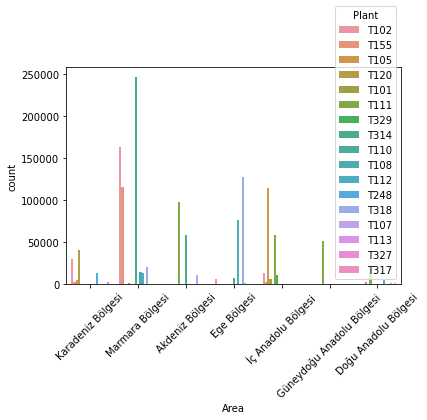

         Product  Ratio-Product
Motorin   826631         60.800
Benzin    532958         39.200
###################################################################################


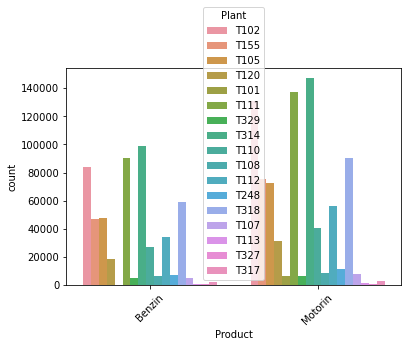

       Plant  Ratio-Plant
T314  246499       18.130
T111  227423       16.727
T102  214910       15.807
T318  149551       11.000
T155  122414        9.004
T105  119881        8.817
T112   90172        6.632
T110   67192        4.942
T120   49988        3.677
T248   18638        1.371
T108   14409        1.060
T107   12406        0.912
T329   11284        0.830
T101    6170        0.454
T317    4664        0.343
T113    2532        0.186
T327    1456        0.107
###################################################################################


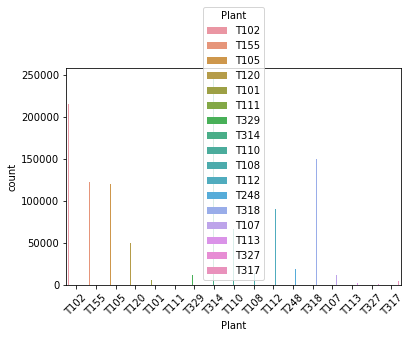

In [33]:
for col_name in cat_cols:
  cat_summary(df , col_name , plot = True)
# Talep %50 neredeyse Marmara bölgesinden kalan %50 de diğer bölgelerden

In [34]:
def num_summary(dataframe,num_col_name,plot=False,quan=False):
    quantiles=[0, 0.05, 0.10, 0.20, 0.30,  0.40, 0.50, 0.60, 0.70, 0.80, 0.90 , 1]
    if quan:
        print(dataframe[num_col_name].describe(quantiles).T)
    else:
        print(dataframe[num_col_name].describe().T)
    if plot:
        sns.histplot(data = dataframe,  x = col_name,kde = True)
        #dataframe[num_col_name].hist(bins=10)
        plt.xlabel(num_col_name)
        plt.title(num_col_name)
        plt.show(block=True)

count    1359589.000
mean    10583420.964
std       939413.857
min     10048261.000
0%      10048261.000
5%      10048928.000
10%     10049027.000
20%     10049240.000
30%     10049413.000
40%     10049568.000
50%     10049880.000
60%     10050078.000
70%     10054986.000
80%     11950417.000
90%     12292058.000
100%    12664221.000
max     12664221.000
Name: Customer, dtype: float64


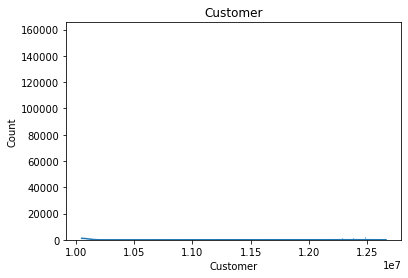

count   1359589.000
mean        698.344
std         232.471
min         116.000
0%          116.000
5%          218.000
10%         367.000
20%         466.000
30%         574.000
40%         676.000
50%         812.000
60%         835.000
70%         835.000
80%         884.000
90%         941.000
100%        990.000
max         990.000
Name: City Code, dtype: float64


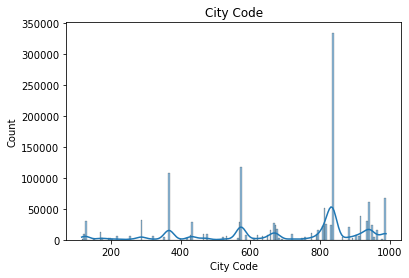

count   1359589.000
mean      14068.357
std       10951.052
min           0.000
0%            0.000
5%         1989.000
10%        3522.000
20%        4781.000
30%        5966.000
40%        9002.000
50%       11476.000
60%       14908.000
70%       18759.000
80%       22729.000
90%       27759.200
100%     273221.000
max      273221.000
Name: Litres, dtype: float64


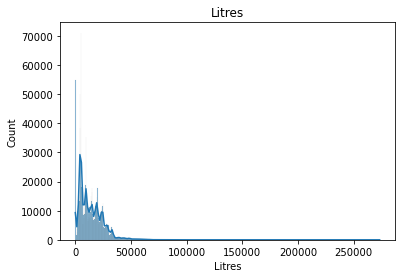

count   1359589.000
mean          4.763
std           0.820
min           3.220
0%            3.220
5%            3.640
10%           3.790
20%           4.030
30%           4.330
40%           4.450
50%           4.590
60%           4.790
70%           5.100
80%           5.400
90%           6.060
100%          7.180
max           7.180
Name: CRP, dtype: float64


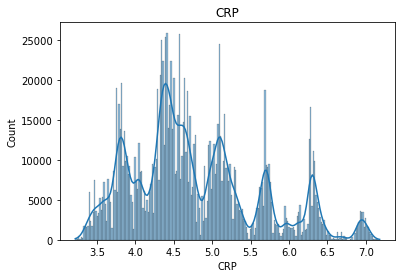

In [35]:
for col_name in num_cols:
    num_summary(df,col_name,plot=True,quan=True)

In [142]:
def high_correlated_cols(dataframe,plot=False,corr_th=0.90):
    corr=dataframe.corr()
    cor_matrix=corr.abs()
    upper_triangle_matrix=cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype("bool"))
    drop_list=[col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col]>corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={"figure.figsize":(15,15)})
        sns.heatmap(corr,cmap="RdBu",annot=True, fmt=".2f")
        plt.show()
    return drop_list

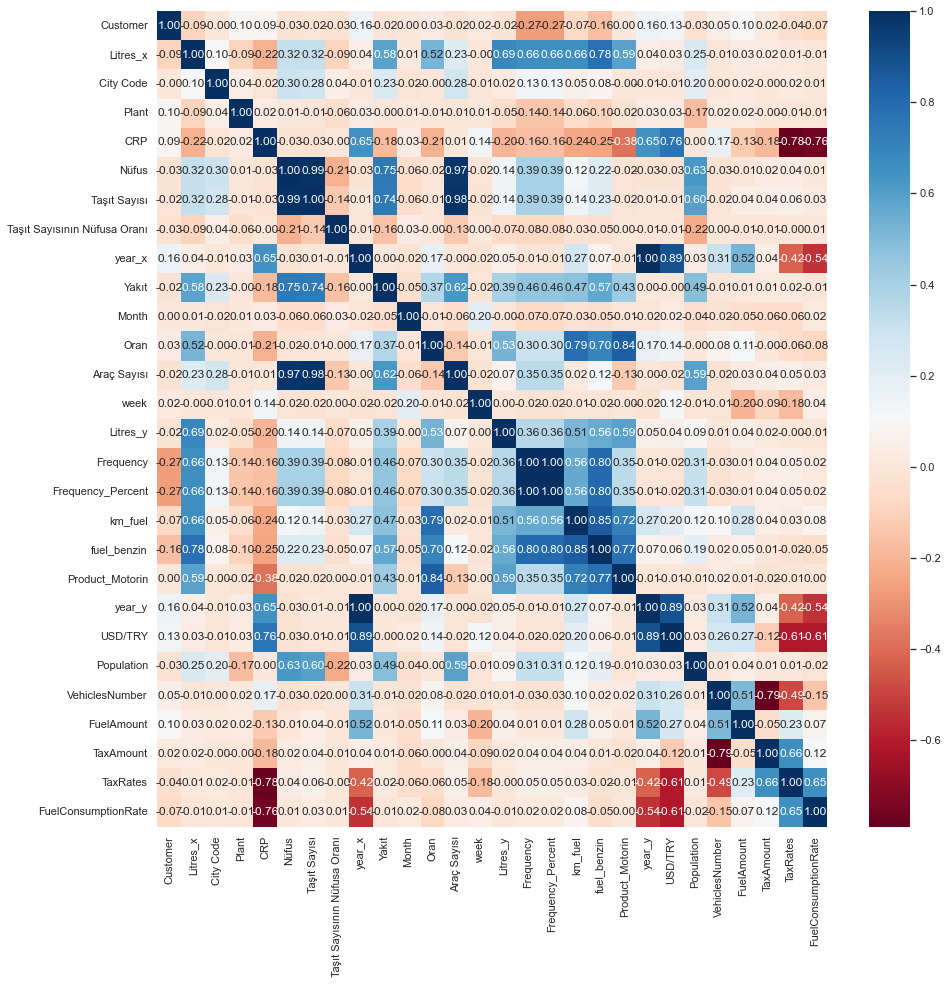

In [143]:
drop_list = high_correlated_cols(cc , plot = True )

In [34]:
drop_list # high corelated variables # can delete that variables

[]

In [39]:
# Hedef Değişkenin Kategorik Değişkenler ile Analizi
def target_summary_with_cat(dataframe,target,categorical_col):
    print(categorical_col.upper())
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}).sort_values(by="TARGET_MEAN",ascending = False), end="\n\n\n")
    print("\n")

In [40]:
for col_name in cat_cols:
    target_summary_with_cat(df , "Litres" , col_name )

AREA
                           TARGET_MEAN
Area                                  
Marmara Bölgesi              15314.373
İç Anadolu Bölgesi           14190.375
Güneydoğu Anadolu Bölgesi    14161.214
Doğu Anadolu Bölgesi         13810.021
Ege Bölgesi                  13129.171
Karadeniz Bölgesi            12817.294
Akdeniz Bölgesi              11652.191




PRODUCT
         TARGET_MEAN
Product             
Motorin    18875.403
Benzin      6612.511




PLANT
       TARGET_MEAN
Plant             
T314     16302.249
T329     15386.783
T102     15212.974
T155     14686.081
T105     14440.897
T108     14241.829
T318     13318.132
T111     13141.729
T327     12797.408
T317     12426.022
T112     12387.039
T107     12075.487
T120     12066.660
T113     11852.400
T248     11687.860
T110     11232.791
T101       299.363






In [41]:
# Hedef Değişkenin Sayısal Değişkenler ile Analizi
def target_summary_with_num(dataframe, target, numerical_col):
    print(numerical_col.upper())
    print(dataframe.groupby(target).agg({numerical_col: ["mean","median"]}), end="\n\n\n")

In [42]:
for col_name in num_cols:
    target_summary_with_num(df, "Litres" , col_name )

CUSTOMER
               Customer             
                   mean       median
Litres                              
0.000      10591997.099 10049720.000
135.000    10049652.000 10049652.000
200.000    10050028.000 10050028.000
239.000    12499577.000 12499577.000
253.000    12292058.000 12292058.000
...                 ...          ...
171670.000 10049254.000 10049254.000
176943.000 10049365.000 10049365.000
188347.000 10049365.000 10049365.000
227877.000 10049943.000 10049943.000
273221.000 12267424.000 12267424.000

[58860 rows x 2 columns]


CITY CODE
           City Code        
                mean  median
Litres                      
0.000        663.676 676.000
135.000      367.000 367.000
200.000      574.000 574.000
239.000      367.000 367.000
253.000      570.000 570.000
...              ...     ...
171670.000   367.000 367.000
176943.000   575.000 575.000
188347.000   575.000 575.000
227877.000   172.000 172.000
273221.000   150.000 150.000

[58860 rows x 2 columns]


L

In [43]:
### train preprocessing

In [44]:
df.head()

,Customer,Area,City Code,date_of_price,Product,Plant,Litres,CRP
0,10048261,Karadeniz Bölgesi,883,2014-01-01,Benzin,T102,0.000,4.980
1,10048261,Karadeniz Bölgesi,883,2014-01-01,Benzin,T155,0.000,4.980
2,10049900,Karadeniz Bölgesi,883,2014-01-01,Benzin,T105,0.000,4.980
3,10048261,Karadeniz Bölgesi,883,2014-01-01,Motorin,T102,0.000,4.580
4,10048261,Karadeniz Bölgesi,883,2014-01-01,Motorin,T155,0.000,4.580


In [45]:
new_train = df.copy()

In [46]:
# date of transaction convert to datetime type
new_train["date_of_price"] = pd.to_datetime(new_train["date_of_price"])

In [47]:
# analysis date choose
import datetime
today = datetime.datetime(2019,12,31)

In [48]:
#new_train = new_train[new_train.Litres>0] 

In [49]:
# total price with amount and quantity
new_train["total_price"] = new_train["CRP"]*new_train["Litres"]

In [50]:
# Recency ve Monetary Values
data_x = new_train.groupby("Customer").agg({"total_price":lambda x: x.sum(),"date_of_price":lambda x: (today-x.max()).days})

# Data is based on stock so that, we make basketid unique
# data_y = new_train.groupby(["individualnumber","basketid"]).agg({"total_price":lambda x: x.sum()})

# basket id is unique and calculate frequency
data_z = new_train.groupby("Customer").agg({"total_price": lambda x: len(x)})

# RFM table 
rfm_table = pd.merge(data_x,data_z,on = "Customer")

# we rename column names
rfm_table.rename(columns = {"date_of_price":"Recency","total_price_y":"Frequency","total_price_x":"Monetary"}, inplace = True)

In [51]:
# RFM Scores

# frequency find
rfm_table = rfm_table.sort_values("Frequency", ascending = True)
rfm_table["freq_tile"] = pd.qcut(rfm_table["Frequency"],5,labels = False,duplicates='drop')


# recency find
rfm_table = rfm_table.sort_values("Frequency", ascending = True)
rfm_table["rec_tile"] = pd.qcut(rfm_table["Recency"],5,labels = False,duplicates='drop')

# monetary find 
rfm_table = rfm_table.sort_values("Frequency", ascending = True)
rfm_table["mone_tile"] = pd.qcut(rfm_table["Monetary"],5,labels = False,duplicates='drop')

# "Sıfır" değeri yer almasın istiyorsak, bulduğumuz değerleri bir arttırıyoruz
rfm_table["freq_tile"] = rfm_table["freq_tile"]+1
rfm_table["rec_tile"] = rfm_table["rec_tile"]+1
rfm_table["mone_tile"] = rfm_table["mone_tile"]+1

# bulduğumuz değerleri birleştirip tek bir skor elde ediyoruz.

rfm_table["rfm_score"]  = rfm_table["rec_tile"].map(str) + rfm_table["freq_tile"].map(str) + rfm_table["mone_tile"].map(str)
rfm_table.head()

,Monetary,Recency,Frequency,freq_tile,rec_tile,mone_tile,rfm_score
Customer,,,,,,,
11814051,0.000,1125,1,1,3,1,311
11798897,0.000,2120,1,1,3,1,311
11818298,0.000,2041,1,1,3,1,311
12073699,0.000,2041,1,1,3,1,311
11802697,0.000,2125,1,1,3,1,311


In [52]:
# değerlerin içeriklerini inceliyoruz 
rfm_table.groupby("rfm_score").agg({
'Recency':["mean","min","max","count"],
'Frequency':["mean","min","max","count"],
'Monetary':["mean","min","max","count"],
}).round(1).head()

Recency                 Frequency                     Monetary                                
             mean  min  max count      mean  min  max count         mean          min          max count
rfm_score                                                                                               
111       365.800  365  367    41   216.200    2  404    41 13269142.300   188109.300 22816693.200    41
112       365.900  365  367    18   357.600  260  417    18 28082271.200 23226713.400 36715425.600    18
114       365.000  365  365     1   372.000  372  372     1 71856172.300 71856172.300 71856172.300     1
121       365.600  365  367    13   586.200  431  801    13 19338022.800 12066128.900 22213718.700    13
122       365.800  365  367    85   653.200  419  817    85 34318724.200 23700231.000 44518574.400    85

In [53]:
rfm_table.groupby("rfm_score").size().sort_values(ascending=False)

rfm_score
155    187
311    152
144    119
133    102
122     85
134     55
143     53
222     47
154     46
145     46
111     41
123     34
132     33
322     27
211     22
233     19
112     18
121     13
321     12
332     11
323     10
223      9
212      7
221      7
312      7
333      7
142      7
153      6
334      6
244      6
344      5
243      5
234      5
232      5
355      5
135      3
245      2
343      2
345      2
254      1
255      1
114      1
224      1
124      1
125      1
131      1
354      1
dtype: int64

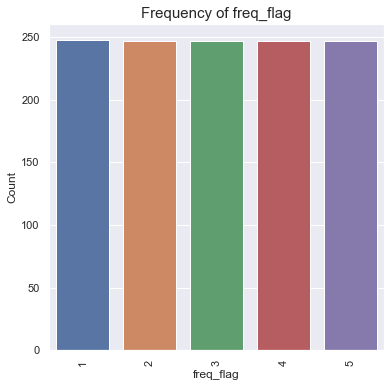

In [54]:
plt.figure(figsize = (6,6))
sns.countplot(x = "freq_tile", data = rfm_table)
plt.ylabel("Count",fontsize = 12)
plt.xlabel("freq_flag", fontsize= 12)
plt.xticks(rotation = "vertical")
plt.title("Frequency of freq_flag",fontsize = 15)
plt.show()

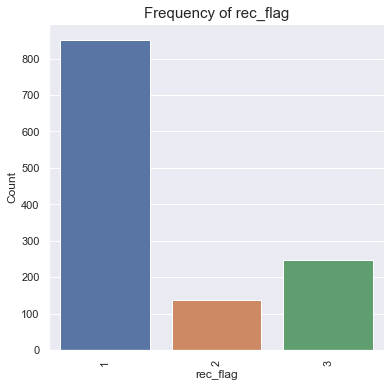

In [55]:
plt.figure(figsize = (6,6))
sns.countplot(x = "rec_tile", data = rfm_table)
plt.ylabel("Count",fontsize = 12)
plt.xlabel("rec_flag", fontsize= 12)
plt.xticks(rotation = "vertical")
plt.title("Frequency of rec_flag",fontsize = 15)
plt.show()

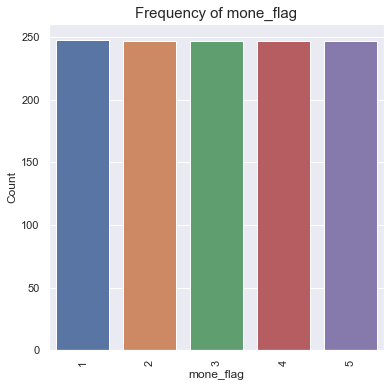

In [56]:
plt.figure(figsize = (6,6))
sns.countplot(x = "mone_tile", data = rfm_table)
plt.ylabel("Count",fontsize = 12)
plt.xlabel("mone_flag", fontsize= 12)
plt.xticks(rotation = "vertical")
plt.title("Frequency of mone_flag",fontsize = 15)
plt.show()

In [57]:
rfm_table.head()

,Monetary,Recency,Frequency,freq_tile,rec_tile,mone_tile,rfm_score
Customer,,,,,,,
11814051,0.000,1125,1,1,3,1,311
11798897,0.000,2120,1,1,3,1,311
11818298,0.000,2041,1,1,3,1,311
12073699,0.000,2041,1,1,3,1,311
11802697,0.000,2125,1,1,3,1,311


In [58]:
# target min inertia and max(1) silhoutte score

In [59]:
# k means
# Noktalar arası uzaklık toplamını minimize etmek ve Kümeler arası uzaklığı maksimize etmek

C:\Users\akdog\.conda\envs\spyder\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


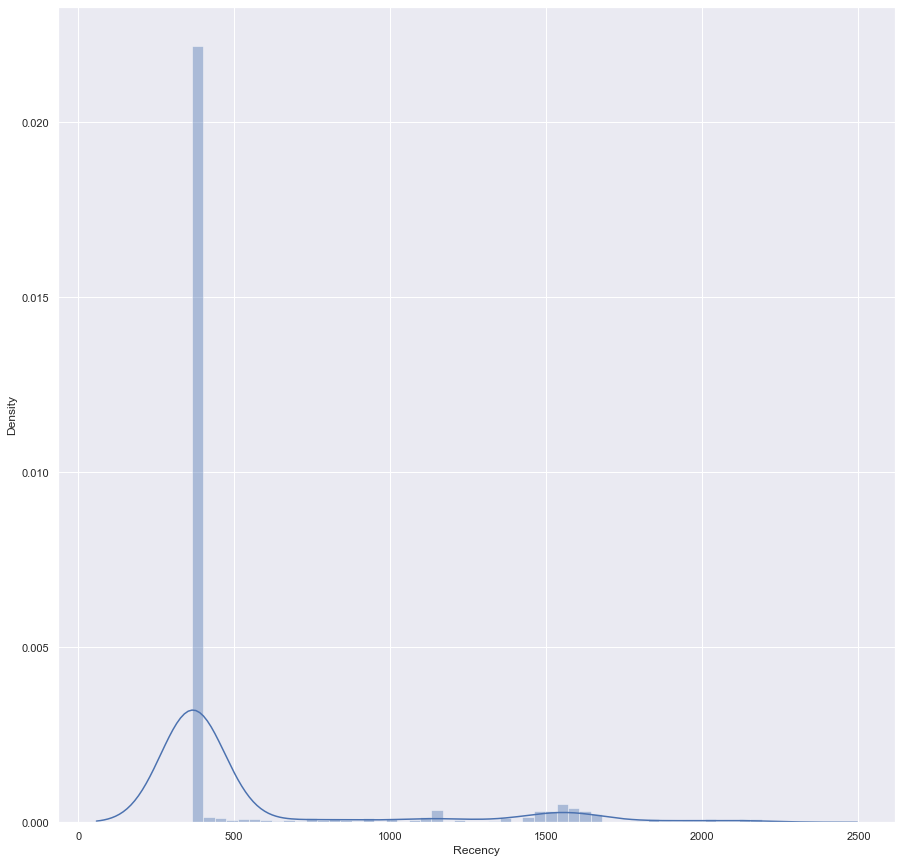

In [60]:
sns.distplot(rfm_table["Recency"])
plt.show()

C:\Users\akdog\.conda\envs\spyder\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


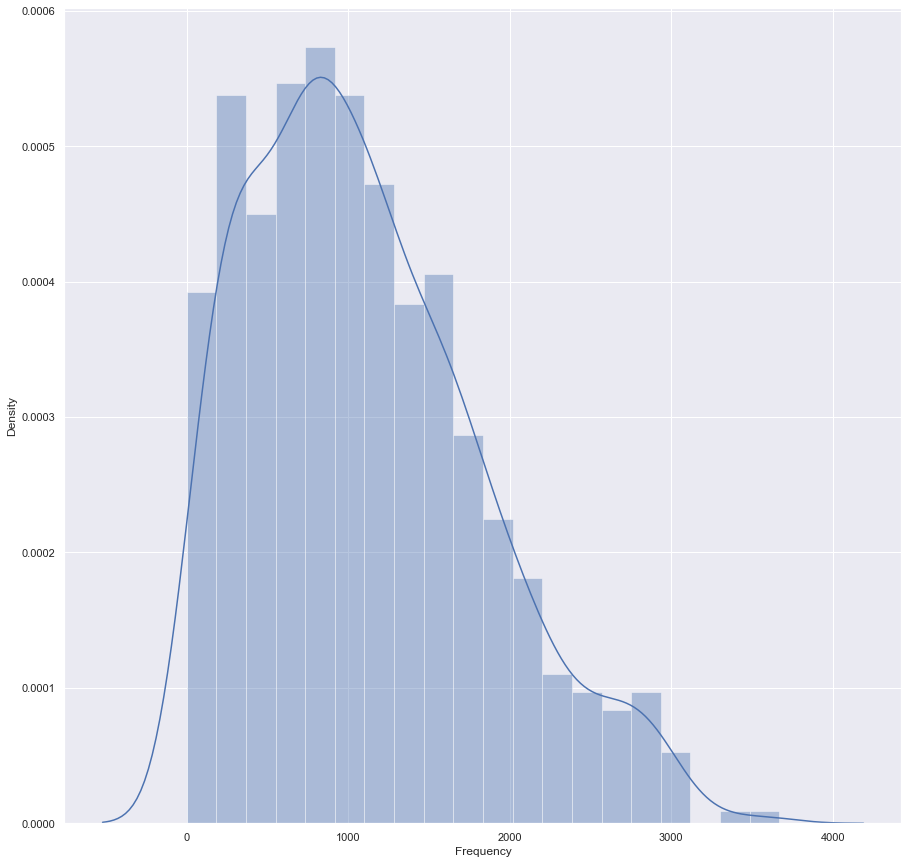

In [61]:
sns.distplot(rfm_table["Frequency"])
plt.show()

C:\Users\akdog\.conda\envs\spyder\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


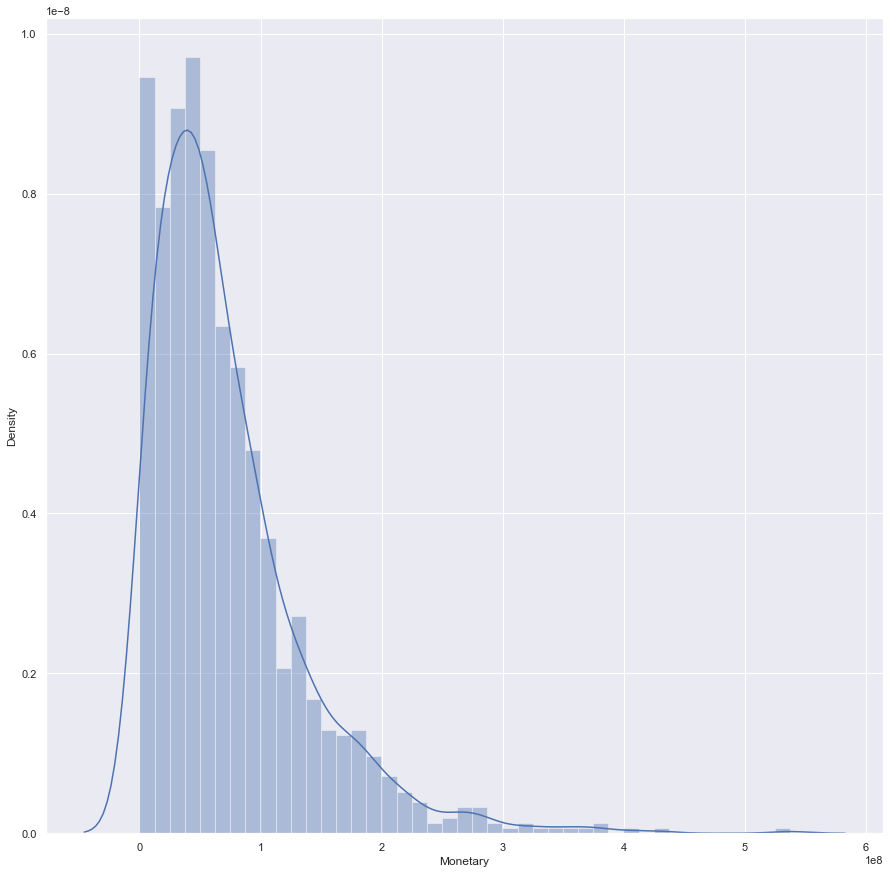

In [62]:
sns.distplot(rfm_table["Monetary"])
plt.show()

In [63]:
clus = rfm_table[["Monetary","Recency","Frequency"]]
clus.head()

,Monetary,Recency,Frequency
Customer,,,
11814051,0.000,1125,1
11798897,0.000,2120,1
11818298,0.000,2041,1
12073699,0.000,2041,1
11802697,0.000,2125,1


In [64]:
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(clus)
data_scaled2 = pd.DataFrame(x_scaled)

In [65]:
data_scaled2.head()

,0,1,2
0,0.000,0.416,0.000
1,0.000,0.962,0.000
2,0.000,0.918,0.000
3,0.000,0.918,0.000
4,0.000,0.964,0.000


In [66]:
data_scaled2.describe()

,0,1,2
count,1236.000,1236.000,1236.000
mean,0.134,0.100,0.300
std,0.118,0.232,0.197
min,0.000,0.000,0.000
25%,0.053,0.000,0.149
50%,0.104,0.000,0.269
75%,0.179,0.002,0.424
max,1.000,1.000,1.000


C:\Users\akdog\.conda\envs\spyder\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\akdog\.conda\envs\spyder\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\akdog\.conda\envs\spyder\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\akdog\.conda\envs\spyder\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is k

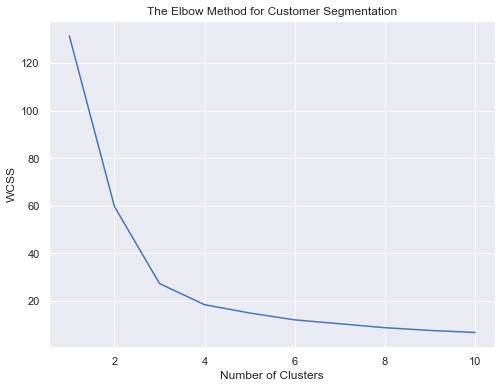

In [67]:
plt.figure(figsize = (8,6))
wcss = []
           
for i in range(1,11):
           kmeans = KMeans(n_clusters = i, init = "k-means++", n_init = 10, max_iter = 3000)
           kmeans.fit(data_scaled2)
           wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title("The Elbow Method for Customer Segmentation")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

In [68]:
# calculate silhoutte score if you want

In [69]:
#############

# k means using 4 clusters and k-means++ initialization
kmeans = KMeans(n_clusters = 4, init = "k-means++", n_init = 10, max_iter = 300)
kmeans.fit(data_scaled2)
pred = kmeans.predict(data_scaled2)

C:\Users\akdog\.conda\envs\spyder\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [70]:
kmeans.inertia_

18.447378501493098

In [71]:
d_frame = pd.DataFrame(clus)
d_frame["cluster"] = pred
d_frame["cluster"].value_counts()

0    501
2    417
1    173
3    145
Name: cluster, dtype: int64

In [72]:
d_frame.head()

,Monetary,Recency,Frequency,cluster
Customer,,,,
11814051,0.000,1125,1,1
11798897,0.000,2120,1,1
11818298,0.000,2041,1,1
12073699,0.000,2041,1,1
11802697,0.000,2125,1,1


In [73]:
d_frame.groupby("cluster").mean()

,Monetary,Recency,Frequency
cluster,,,
0,37513496.365,395.096,654.523
1,16867052.671,1547.503,318.728
2,91401685.878,375.436,1483.122
3,199962469.525,376.159,2469.455


In [154]:
cat_cols,num_cols,car=grab_col(train)

In [161]:
# Aykırı değer eşik değerlerini belirleyelim
def outlier_thresholds(dataframe,col_name,q1=0.25,q3=0.75):
    quartile1=dataframe[col_name].quantile(q1)
    quartile3=dataframe[col_name].quantile(q3)
    interquartile=quartile3-quartile1
    low_limit=quartile1-1.5*interquartile
    up_limit=quartile3+1.5*interquartile
    return low_limit,up_limit

In [176]:
def check_outlier(dataframe,col_name,q1=0.25,q3=0.75):
    low_limit,up_limit=outlier_thresholds(dataframe,col_name,q1=q1,q3=q3)
    print(col_name)
    if dataframe.loc[(dataframe[col_name]>up_limit) | (dataframe[col_name]<low_limit),:].any(axis=None):
        dataframe.loc[(dataframe[col_name]>up_limit)| (dataframe[col_name]<low_limit)].index
        return True
    else:
        return False

In [178]:
for col_name in num_cols:
    print(check_outlier(train,col_name,q1=0.05,q3=0.95))

Customer
False
Litres_x
False
City Code
False
Plant
False
CRP
False
Nüfus
False
Taşıt Sayısı
False
Taşıt Sayısının Nüfusa Oranı
False
Yakıt
False
Month
False
Araç Sayısı
False
week
False
Frequency
False
Frequency_Percent
False
km_fuel
False
fuel_benzin
False


In [164]:
# aykırı değerlerin indexlerini çekelim ve gözlem birimlerine erişelim
def grab_outliers(dataframe,col_name,index=False,q1=0.25,q3=0.75):
    low,up=outlier_thresholds(dataframe,col_name,q1=q1,q3=q3)
    
    if dataframe[((dataframe[col_name]<low) | (dataframe[col_name]>up))].shape[0]>10:
        print(dataframe[((dataframe[col_name]<low) | (dataframe[col_name]>up))].head())
    else:
        print(dataframe[((dataframe[col_name]<low)| (dataframe[col_name]>up))])
    if index:
        outlier_index=dataframe[((dataframe[col_name]<low)|(dataframe[col_name]>up))].index
    return outlier_index

In [170]:
outlier_index=grab_outliers(train,"Litres_x",index=True,q1=0.25,q3=0.75)
len(outlier_index)

          Customer Billing Date   Litres_x             Area  City Code Product  Plant   CRP     Sehir        Nüfus  Taşıt Sayısı  Taşıt Sayısının Nüfusa Oranı  year      Yakıt  Month  Oran  Araç Sayısı  week    ind  Frequency  Frequency_Percent  km_fuel  fuel_benzin  Product_Motorin
35071 10049419.000   2014-02-02 131634.000  Marmara Bölgesi    835.000  Benzin  0.000 5.080  İstanbul 15067724.000   4187531.000                        27.800  2014 171942.000  0.710 0.290 14439762.069     5  train   1897.000              0.129    0.000    64087.273            0.000
35075 10049419.000   2014-03-02 132175.000  Marmara Bölgesi    835.000  Benzin  0.000 5.080  İstanbul 15067724.000   4187531.000                        27.800  2014 171942.000  0.810 0.290 14439762.069     9  train   1897.000              0.129    0.000    64087.273            0.000
35079 10049419.000   2014-03-30 132091.000  Marmara Bölgesi    835.000  Benzin  0.000 5.050  İstanbul 15067724.000   4187531.000                    

19740

<AxesSubplot:xlabel='Litres_x'>

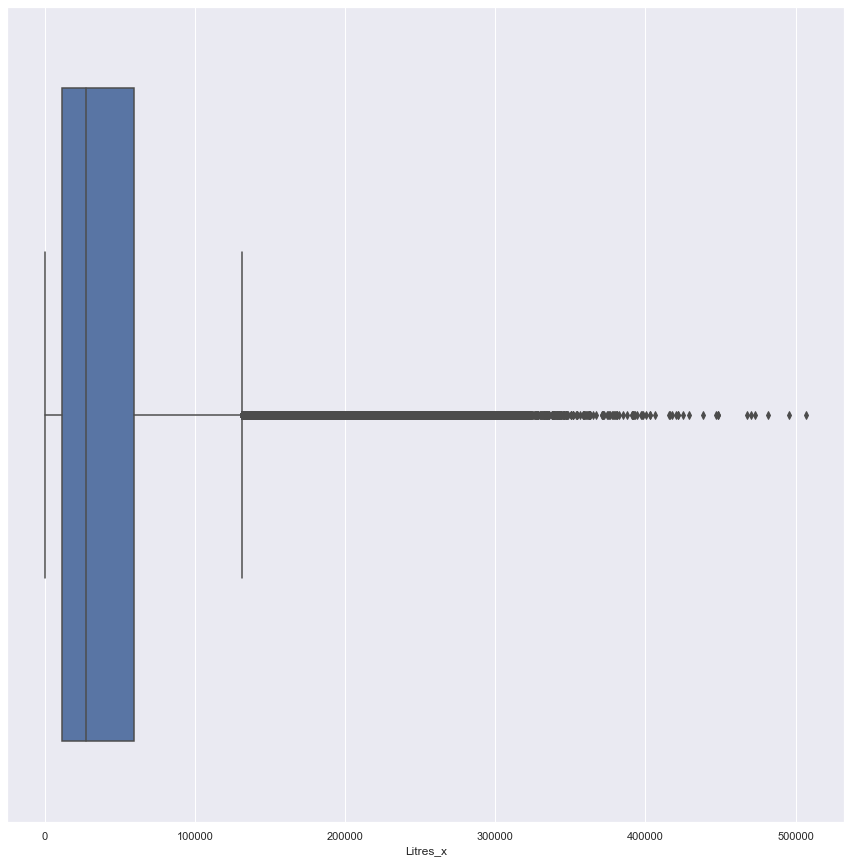

In [167]:
sns.boxplot(x=train["Litres_x"])

In [171]:
def replace_with_thresholds(dataframe,col_name,q1=0.25,q3=0.75):
    low_limit,up_limit=outlier_thresholds(dataframe,col_name,q1=q1,q3=q3)
    dataframe.loc[(dataframe[col_name]<low_limit),col_name]=low_limit
    dataframe.loc[(dataframe[col_name]>up_limit),col_name]=up_limit

In [174]:
replace_with_thresholds(train,"Litres_x")

<AxesSubplot:xlabel='Litres_x'>

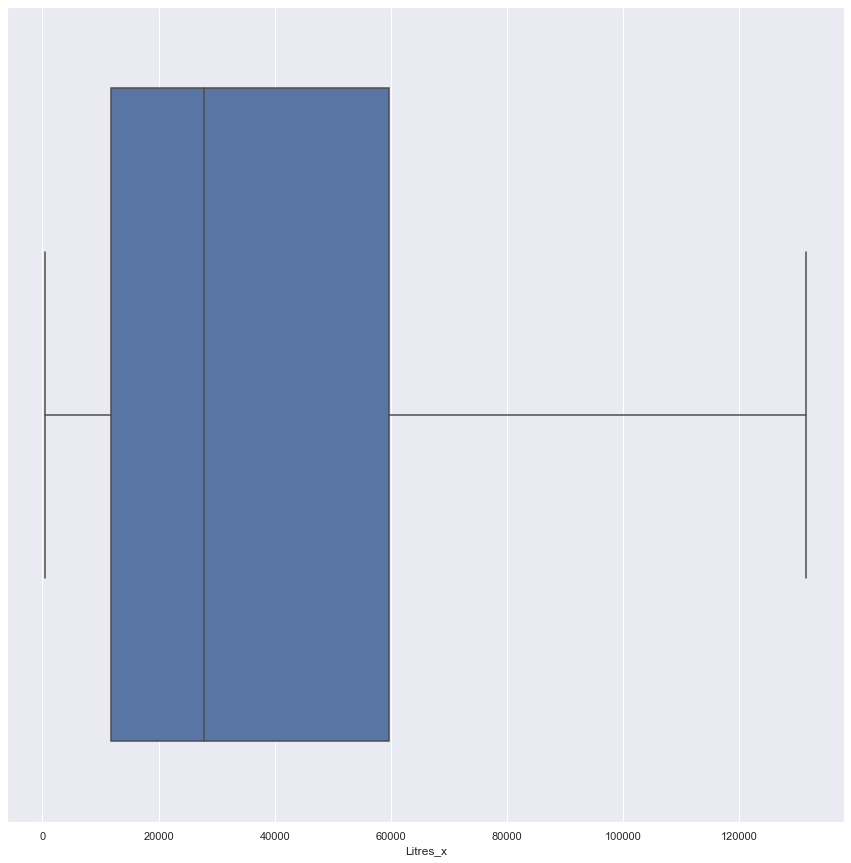

In [175]:
sns.boxplot(x=train["Litres_x"])

In [179]:
df = pd.concat([test.assign(ind="test"), train.assign(ind="train")])

In [195]:
# new features

In [35]:
df["date_of_price"] = pd.to_datetime(df["date_of_price"])
df["month"] = df.date_of_price.dt.month
df["week"] = df.date_of_price.dt.isocalendar().week
df["year"] = df.date_of_price.dt.year

In [274]:
df_customer_product = df.groupby(["Customer","Product"])[["Area"]].count().reset_index()

In [275]:
df_customer_product["area_percent_customer_product"] = ((df.groupby(["Customer","Product"])[["Area"]].count().reset_index()[["Area"]])/(df.groupby(["Customer","Product"])[["Area"]].count().reset_index()[["Area"]].sum()))*(100)

In [56]:
#df.groupby(["Customer","season_y","Product"])[["Area"]].count().reset_index().head(50)

,Customer,season_y,Product,Area
0,10048261,1,Benzin,74
1,10048261,1,Motorin,76
2,10048261,2,Benzin,78
3,10048261,2,Motorin,77
4,10048261,3,Benzin,78
5,10048261,3,Motorin,78
6,10048261,4,Benzin,78
7,10048261,4,Motorin,77
8,10048263,1,Benzin,44
9,10048263,1,Motorin,65


In [53]:
# df_customer = ((df.groupby(["Customer"])[["Area"]].count().reset_index()[["Area"]])/(df.groupby(["Customer"])[["Area"]].count().reset_index()[["Area"]].sum()))*100

In [54]:
# birleştirme

In [109]:
df.head()

,index,Customer,Area,City Code,Product,date_of_price,month_x,week_x,year_x,season_x,CRP,month_y,week_y,year_y,season_y,ind,Litres
0,0.000,10048261,Karadeniz Bölgesi,883,Motorin,2019-01-07,1,2,2019,1,5.760,1,2,2019,1,test,NaN
1,104.000,10048264,Karadeniz Bölgesi,883,Motorin,2019-01-07,1,2,2019,1,5.760,1,2,2019,1,test,NaN
2,23660.000,10049900,Karadeniz Bölgesi,883,Motorin,2019-01-07,1,2,2019,1,5.760,1,2,2019,1,test,NaN
3,30524.000,10051287,Karadeniz Bölgesi,883,Motorin,2019-01-07,1,2,2019,1,5.760,1,2,2019,1,test,NaN
4,48724.000,12498499,Karadeniz Bölgesi,883,Motorin,2019-01-07,1,2,2019,1,5.760,1,2,2019,1,test,NaN


In [276]:
new_df = df.merge(df_customer_product,on=["Customer","Product"])

In [277]:
new_df.columns

Index(['index', 'Customer', 'Area_x', 'City Code', 'Product', 'Billing Date', 'CRP', 'Week_Number', 'Plant', 'Sehir', 'Nüfus', 'Taşıt Sayısı', 'Taşıt Sayısının Nüfusa Oranı', 'year', 'Yakıt', 'Month', 'Oran', 'Araç Sayısı', 'week', 'Frequency', 'km_fuel', 'fuel_benzin', 'Product_Motorin', '_merge', 'ind', 'Litres_x', 'Frequency_Percent', 'Area_y', 'area_percent_customer_product'], dtype='object')

In [112]:
new_df.drop(["Plant"],axis=1,inplace=True)

KeyError: "['Plant'] not found in axis"

In [72]:
new_df.drop(["month_y","week_y","year_y","season_y"],axis=1,inplace=True)

In [278]:
new_df.columns

Index(['index', 'Customer', 'Area_x', 'City Code', 'Product', 'Billing Date', 'CRP', 'Week_Number', 'Plant', 'Sehir', 'Nüfus', 'Taşıt Sayısı', 'Taşıt Sayısının Nüfusa Oranı', 'year', 'Yakıt', 'Month', 'Oran', 'Araç Sayısı', 'week', 'Frequency', 'km_fuel', 'fuel_benzin', 'Product_Motorin', '_merge', 'ind', 'Litres_x', 'Frequency_Percent', 'Area_y', 'area_percent_customer_product'], dtype='object')

In [279]:
new_df.columns = ['index', 'Customer', 'Area_x', 'City Code', 'Product', 'Billing Date', 'CRP', 'Week_Number', 'Plant', 'Sehir', 'Nüfus', 'Taşıt Sayısı', 'Taşıt Sayısının Nüfusa Oranı', 'year', 'Yakıt', 'Month', 'Oran', 'Araç Sayısı', 'week', 'Frequency', 'km_fuel', 'fuel_benzin', 'Product_Motorin', '_merge', 'ind', 'Litres_x', 'Frequency_Percent', 'Area_y', 'area_percent_customer_product']

In [75]:
# feature load

In [180]:
def km_statistics(dataframe):
    benzin = dataframe.iloc[[3,10],[3]].sum()
    motorin = dataframe.iloc[[4,5,6,7,8,9],[3]].sum()
    total = dataframe.iloc[[1],[3]]
    benzin_to_total = benzin/total
    motorin_to_total = motorin/total
    return benzin_to_total,motorin_to_total

In [181]:
km_15 = pd.read_excel("15-kilometre istatistikleri (3).xls")
km_16 = pd.read_excel("16_tasit-kilometre istatistikleri (2).xls")
km_17 = pd.read_excel("17-kilometre istatistikleri (1).xls")
km_18_19 = pd.read_excel("18-19_tasit-kilometre istatistikleri.xls")

In [182]:
bk_17 = km_17.iloc[[2,9],[3]].sum()/km_17.iloc[[0],[3]]
mk_17 = km_17.iloc[[3,4,5,6,7,8],[3]].sum()/km_17.iloc[[0],[3]]

In [183]:
bk_15,mk_15 = km_statistics(km_15)
bk_16,mk_16 = km_statistics(km_16)

In [184]:
bk_18 = km_18_19.iloc[[3,10],[3]].sum()/km_18_19.iloc[[1],[3]]
mk_18 = km_18_19.iloc[[4,5,6,7,8,9],[3]].sum()/km_18_19.iloc[[1],[3]]
bk_19 = km_18_19.iloc[[3,10],[6]].sum()/km_18_19.iloc[[1],[6]]
mk_19 = km_18_19.iloc[[4,5,6,7,8,9],[6]].sum()/km_18_19.iloc[[1],[6]]

In [185]:
def km_statistics_per(dataframe):
    benzin = dataframe.iloc[[3,10],[2]].sum()
    motorin = dataframe.iloc[[4,5,6,7,8,9],[3]].sum()
    total = dataframe.iloc[[1],[3]]
    benzin_to_total = benzin/total
    motorin_to_total = motorin/total
    return benzin_to_total,motorin_to_total

In [186]:
def vehicle_type(dataframe):
    vt_14 = dataframe.iloc[[0],[1,2,3,4,5,6,7,8,10]]
    vt_15 = dataframe.iloc[[1],[1,2,3,4,5,6,7,8,10]]
    vt_16 = dataframe.iloc[[2],[1,2,3,4,5,6,7,8,10]]
    vt_17 = dataframe.iloc[[3],[1,2,3,4,5,6,7,8,10]]
    vt_18 = dataframe.iloc[[4],[1,2,3,4,5,6,7,8,10]]
    vt_19 = dataframe.iloc[[5],[1,2,3,4,5,6,7,8,10]]
    return vt_14,vt_15,vt_16,vt_17,vt_18,vt_19

In [187]:
vt = pd.read_excel("kara tasit sayisi_tür.xls")
vt_14,vt_15,vt_16,vt_17,vt_18,vt_19 = vehicle_type(vt)  

In [188]:
def engine_volume(dataframe):
    en_14 = dataframe.iloc[[2,3,4,5,6,7,8],[0,1]]
    en_15 = dataframe.iloc[[2,3,4,5,6,7,8],[0,3]]
    en_16 = dataframe.iloc[[2,3,4,5,6,7,8],[0,5]]
    en_17 = dataframe.iloc[[2,3,4,5,6,7,8],[0,7]]
    en_18 = dataframe.iloc[[2,3,4,5,6,7,8],[0,9]]
    en_19 = dataframe.iloc[[2,3,4,5,6,7,8],[0,11]]
    return en_14,en_15,en_16,en_17,en_18,en_19

In [189]:
engine_volumes = pd.read_excel("motor silindir hacimlerine gore dagilimi (1).xls")
en_14,en_15,en_16,en_17,en_18,en_19 = engine_volume(engine_volumes)

In [190]:
def fuel_vehicle(dataframe):
    fuel_14 = dataframe.iloc[[0],[0,1,2,4,6]]
    fuel_15 = dataframe.iloc[[1],[0,1,2,4,6]]
    fuel_16 = dataframe.iloc[[2],[0,1,2,4,6]]
    fuel_17 = dataframe.iloc[[3],[0,1,2,4,6]]
    fuel_18 = dataframe.iloc[[4],[0,1,2,4,6]]
    fuel_19 = dataframe.iloc[[5],[0,1,2,4,6]]
    return fuel_14,fuel_15,fuel_16,fuel_17,fuel_18,fuel_19

In [191]:
fuel__type_vehicle = pd.read_excel("otomobillerin yakit cinsine gore dagilimi.xls")
fuel_14,fuel_15,fuel_16,fuel_17,fuel_18,fuel_19 = fuel_vehicle(fuel__type_vehicle)

In [192]:
new_df=df.copy()

In [193]:
new_df["km_fuel_new"] = np.nan

In [194]:
new_df.drop(["km_fuel_new"],axis=1,inplace=True)

In [294]:
new_df.loc[(new_df.year==2015)&(new_df.Product=="Benzin"),"km_fuel_new"] = new_df.loc[(new_df.year==2015)&(new_df.Product=="Benzin"),'area_percent_customer_product']*bk_15.iloc[0,0]*0.1602
new_df.loc[(new_df.year==2016)&(new_df.Product=="Benzin"),"km_fuel_new"] = new_df.loc[(new_df.year==2016)&(new_df.Product=="Benzin"),'area_percent_customer_product']*bk_16.iloc[0,0]*0.1610
new_df.loc[(new_df.year==2017)&(new_df.Product=="Benzin"),"km_fuel_new"] = new_df.loc[(new_df.year==2017)&(new_df.Product=="Benzin"),'area_percent_customer_product']*bk_17.iloc[0,0]*0.1520
new_df.loc[(new_df.year==2018)&(new_df.Product=="Benzin"),"km_fuel_new"] = new_df.loc[(new_df.year==2018)&(new_df.Product=="Benzin"),'area_percent_customer_product']*bk_18.values[0,0]*0.1599
new_df.loc[(new_df.year==2019)&(new_df.Product=="Benzin"),"km_fuel_new"] = new_df.loc[(new_df.year==2019)&(new_df.Product=="Benzin"),'area_percent_customer_product']*bk_19.values[0,0]*0.1611
new_df.loc[(new_df.year==2014)&(new_df.Product=="Benzin"),"km_fuel_new"] = new_df.loc[(new_df.year==2014)&(new_df.Product=="Benzin"),'area_percent_customer_product']*new_df.km_fuel.mean()*0.1737


new_df.loc[(new_df.year==2015)&(new_df.Product=="Motorin"),"km_fuel_new"] = new_df.loc[(new_df.year==2015)&(new_df.Product=="Motorin"),'area_percent_customer_product']*mk_15.iloc[0,0]*0.1602
new_df.loc[(new_df.year==2016)&(new_df.Product=="Motorin"),"km_fuel_new"] = new_df.loc[(new_df.year==2016)&(new_df.Product=="Motorin"),'area_percent_customer_product']*mk_16.iloc[0,0]*0.1610
new_df.loc[(new_df.year==2017)&(new_df.Product=="Motorin"),"km_fuel_new"] = new_df.loc[(new_df.year==2017)&(new_df.Product=="Motorin"),'area_percent_customer_product']*mk_17.iloc[0,0]*0.1520
new_df.loc[(new_df.year==2018)&(new_df.Product=="Motorin"),"km_fuel_new"] = new_df.loc[(new_df.year==2018)&(new_df.Product=="Motorin"),'area_percent_customer_product']*mk_18.values[0,0]*0.1599
new_df.loc[(new_df.year==2019)&(new_df.Product=="Motorin"),"km_fuel_new"] = new_df.loc[(new_df.year==2019)&(new_df.Product=="Motorin"),'area_percent_customer_product']*mk_19.values[0,0]*0.
new_df.loc[(new_df.year==2014)&(new_df.Product=="Motorin"),"km_fuel_new"] = new_df.loc[(new_df.year==2014)&(new_df.Product=="Motorin"),'area_percent_customer_product']*new_df.km_fuel.mean()*0.1737

In [195]:
def high_correlated_cols(dataframe,plot=False,corr_th=0.90):
    corr=dataframe.corr()
    cor_matrix=corr.abs()
    upper_triangle_matrix=cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype("bool"))
    drop_list=[col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col]>corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={"figure.figsize":(15,15)})
        sns.heatmap(corr,cmap="RdBu",annot=True, fmt=".2f")
        plt.show()
    return drop_list

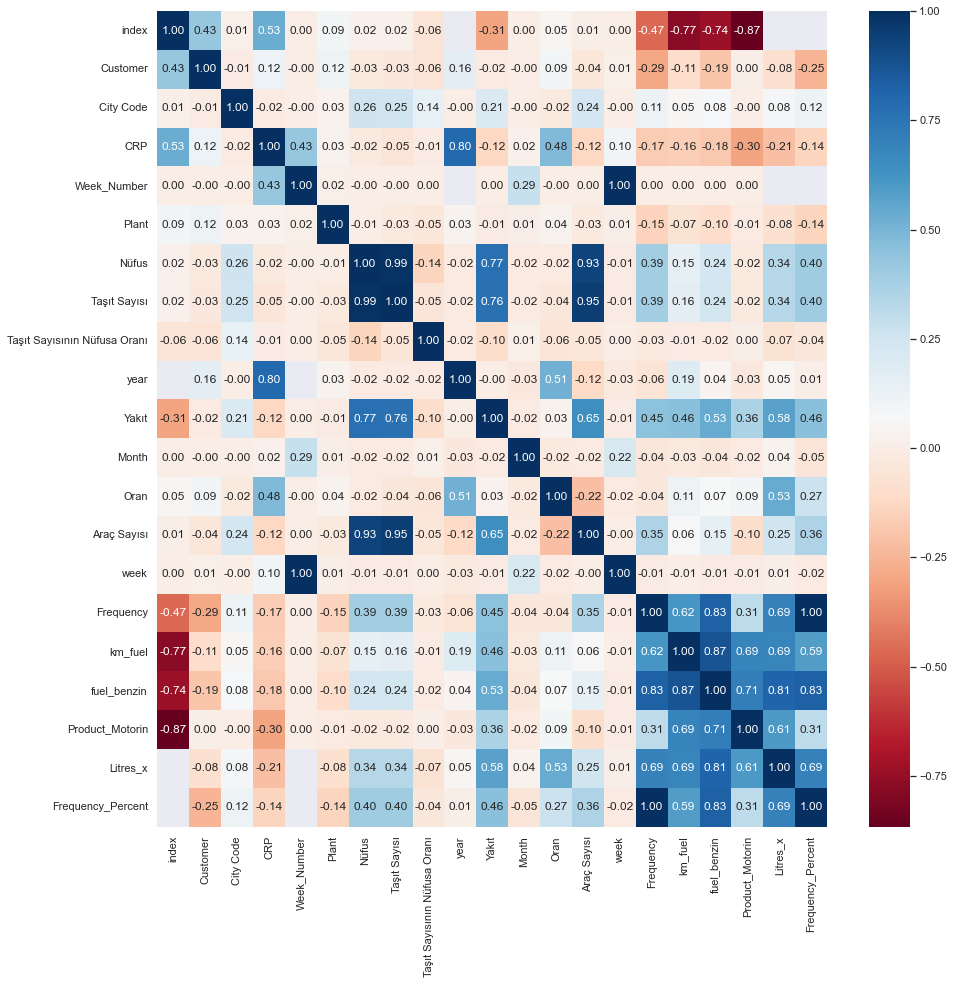

In [196]:
drop_list = high_correlated_cols(new_df , plot = True )

In [197]:
new_df=df.copy()

In [545]:
t_14=0.1737
t_15=0.1602
t_16=0.1610
t_17=0.1520
t_18=0.1599
t_19=0.1611

In [198]:
new_df["car_number"] = 0
new_df.loc[new_df.year==2014,"car_number"] = new_df.loc[new_df.year==2014,'Frequency_Percent']* (vt_14.iloc[0,[1]][0])
new_df.loc[new_df.year==2015,"car_number"] = new_df.loc[new_df.year==2015,'Frequency_Percent']* (vt_15.iloc[0,[1]][0])
new_df.loc[new_df.year==2016,"car_number"] = new_df.loc[new_df.year==2016,'Frequency_Percent']* (vt_16.iloc[0,[1]][0])
new_df.loc[new_df.year==2017,"car_number"] = new_df.loc[new_df.year==2017,'Frequency_Percent']* (vt_17.iloc[0,[1]][0])
new_df.loc[new_df.year==2018,"car_number"] = new_df.loc[new_df.year==2018,'Frequency_Percent']* (vt_18.iloc[0,[1]][0])
new_df.loc[new_df.year==2019,"car_number"] = new_df.loc[new_df.year==2019,'Frequency_Percent']* (vt_19.iloc[0,[1]][0])

In [199]:
new_df["minibus_number"] = 0
new_df.loc[new_df.year==2014,"minibus_number"] = new_df.loc[new_df.year==2014,'Frequency_Percent']* (vt_14.iloc[0,[2]][0])   
new_df.loc[new_df.year==2015,"minibus_number"] = new_df.loc[new_df.year==2015,'Frequency_Percent']* (vt_15.iloc[0,[2]][0])
new_df.loc[new_df.year==2016,"minibus_number"] = new_df.loc[new_df.year==2016,'Frequency_Percent']* (vt_16.iloc[0,[2]][0])
new_df.loc[new_df.year==2017,"minibus_number"] = new_df.loc[new_df.year==2017,'Frequency_Percent']* (vt_17.iloc[0,[2]][0])
new_df.loc[new_df.year==2018,"minibus_number"] = new_df.loc[new_df.year==2018,'Frequency_Percent']* (vt_18.iloc[0,[2]][0])
new_df.loc[new_df.year==2019,"minibus_number"] = new_df.loc[new_df.year==2019,'Frequency_Percent']* (vt_19.iloc[0,[2]][0])

In [200]:
new_df["bus_number"] = 0
new_df.loc[new_df.year==2014,"bus_number"] = new_df.loc[new_df.year==2014,"Frequency_Percent"]* (vt_14.iloc[0,[3]][0])
new_df.loc[new_df.year==2015,"bus_number"] = new_df.loc[new_df.year==2015,"Frequency_Percent"]* (vt_15.iloc[0,[3]][0])
new_df.loc[new_df.year==2016,"bus_number"] = new_df.loc[new_df.year==2016,"Frequency_Percent"]* (vt_16.iloc[0,[3]][0])
new_df.loc[new_df.year==2017,"bus_number"] = new_df.loc[new_df.year==2017,"Frequency_Percent"]* (vt_17.iloc[0,[3]][0])
new_df.loc[new_df.year==2018,"bus_number"] = new_df.loc[new_df.year==2018,"Frequency_Percent"]* (vt_18.iloc[0,[3]][0])
new_df.loc[new_df.year==2019,"bus_number"] = new_df.loc[new_df.year==2019,"Frequency_Percent"]* (vt_19.iloc[0,[3]][0])

In [201]:
new_df["truck_number"] = 0
new_df.loc[new_df.year==2014,"truck_number"] = new_df.loc[new_df.year==2014,"Frequency_Percent"]* (vt_14.iloc[0,[4]][0])
new_df.loc[new_df.year==2015,"truck_number"] = new_df.loc[new_df.year==2015,"Frequency_Percent"]* (vt_15.iloc[0,[4]][0])
new_df.loc[new_df.year==2016,"truck_number"] = new_df.loc[new_df.year==2016,"Frequency_Percent"]* (vt_16.iloc[0,[4]][0])
new_df.loc[new_df.year==2017,"truck_number"] = new_df.loc[new_df.year==2017,"Frequency_Percent"]* (vt_17.iloc[0,[4]][0])
new_df.loc[new_df.year==2018,"truck_number"] = new_df.loc[new_df.year==2018,"Frequency_Percent"]* (vt_18.iloc[0,[4]][0])
new_df.loc[new_df.year==2019,"truck_number"] = new_df.loc[new_df.year==2019,"Frequency_Percent"]* (vt_19.iloc[0,[4]][0])

In [202]:
new_df["truck_big_number"] = 0
new_df.loc[new_df.year==2014,"truck_big_number"] = new_df.loc[new_df.year==2014,"Frequency_Percent"]* (vt_14.iloc[0,[5]][0])
new_df.loc[new_df.year==2015,"truck_big_number"] = new_df.loc[new_df.year==2015,"Frequency_Percent"]* (vt_15.iloc[0,[5]][0])
new_df.loc[new_df.year==2016,"truck_big_number"] = new_df.loc[new_df.year==2016,"Frequency_Percent"]* (vt_16.iloc[0,[5]][0])
new_df.loc[new_df.year==2017,"truck_big_number"] = new_df.loc[new_df.year==2017,"Frequency_Percent"]* (vt_17.iloc[0,[5]][0])
new_df.loc[new_df.year==2018,"truck_big_number"] = new_df.loc[new_df.year==2018,"Frequency_Percent"]* (vt_18.iloc[0,[5]][0])
new_df.loc[new_df.year==2019,"truck_big_number"] = new_df.loc[new_df.year==2019,"Frequency_Percent"]* (vt_19.iloc[0,[5]][0])

In [203]:
new_df["motorcycle_number"] = 0
new_df.loc[new_df.year==2014,"motorcycle_number"] = new_df.loc[new_df.year==2014,"Frequency_Percent"]* (vt_14.iloc[0,[6]][0])
new_df.loc[new_df.year==2015,"motorcycle_number"] = new_df.loc[new_df.year==2015,"Frequency_Percent"]* (vt_15.iloc[0,[6]][0])
new_df.loc[new_df.year==2016,"motorcycle_number"] = new_df.loc[new_df.year==2016,"Frequency_Percent"]* (vt_16.iloc[0,[6]][0])
new_df.loc[new_df.year==2017,"motorcycle_number"] = new_df.loc[new_df.year==2017,"Frequency_Percent"]* (vt_17.iloc[0,[6]][0])
new_df.loc[new_df.year==2018,"motorcycle_number"] = new_df.loc[new_df.year==2018,"Frequency_Percent"]* (vt_18.iloc[0,[6]][0])
new_df.loc[new_df.year==2019,"motorcycle_number"] = new_df.loc[new_df.year==2019,"Frequency_Percent"]* (vt_19.iloc[0,[6]][0])

In [204]:
new_df["vehicles_number"] = 0
new_df.loc[new_df.year==2014,"vehicles_number"] = new_df.loc[new_df.year==2014,"Frequency_Percent"]* (vt_14.iloc[0,[7]][0])
new_df.loc[new_df.year==2015,"vehicles_number"] = new_df.loc[new_df.year==2015,"Frequency_Percent"]* (vt_15.iloc[0,[7]][0])
new_df.loc[new_df.year==2016,"vehicles_number"] = new_df.loc[new_df.year==2016,"Frequency_Percent"]* (vt_16.iloc[0,[7]][0])
new_df.loc[new_df.year==2017,"vehicles_number"] = new_df.loc[new_df.year==2017,"Frequency_Percent"]* (vt_17.iloc[0,[7]][0])
new_df.loc[new_df.year==2018,"vehicles_number"] = new_df.loc[new_df.year==2018,"Frequency_Percent"]* (vt_18.iloc[0,[7]][0])
new_df.loc[new_df.year==2019,"vehicles_number"] = new_df.loc[new_df.year==2019,"Frequency_Percent"]* (vt_19.iloc[0,[7]][0])

In [205]:
new_df["tractor_number"] = 0
new_df.loc[new_df.year==2014,"tractor_number"] = new_df.loc[new_df.year==2014,"Frequency_Percent"]* (vt_14.iloc[0,[8]][0])
new_df.loc[new_df.year==2015,"tractor_number"] = new_df.loc[new_df.year==2015,"Frequency_Percent"]* (vt_15.iloc[0,[8]][0])
new_df.loc[new_df.year==2016,"tractor_number"] = new_df.loc[new_df.year==2016,"Frequency_Percent"]* (vt_16.iloc[0,[8]][0])
new_df.loc[new_df.year==2017,"tractor_number"] = new_df.loc[new_df.year==2017,"Frequency_Percent"]* (vt_17.iloc[0,[8]][0])
new_df.loc[new_df.year==2018,"tractor_number"] = new_df.loc[new_df.year==2018,"Frequency_Percent"]* (vt_18.iloc[0,[8]][0])
new_df.loc[new_df.year==2019,"tractor_number"] = new_df.loc[new_df.year==2019,"Frequency_Percent"]* (vt_19.iloc[0,[8]][0])

In [556]:
new_df.shape

(1367692, 88)

In [560]:
import matplotlib 
matplotlib.rc('xtick', labelsize=50) 
matplotlib.rc('ytick', labelsize=50) 

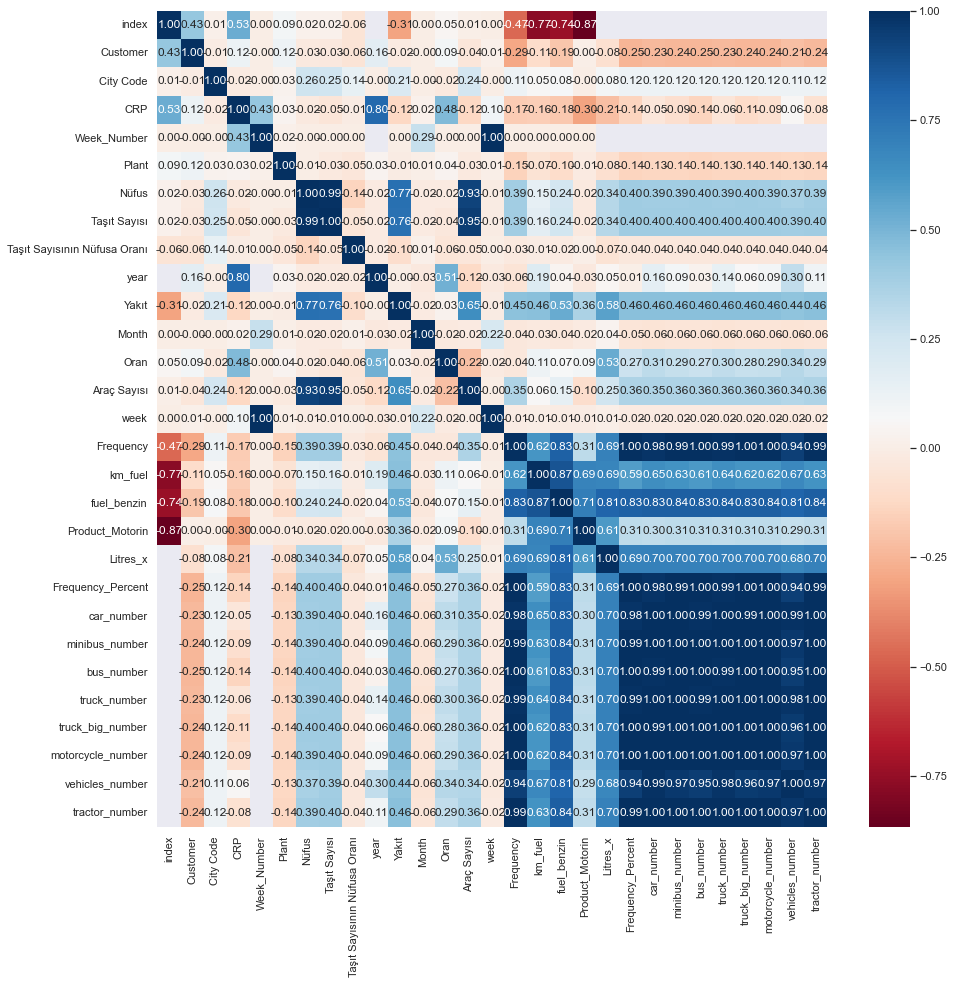

['Taşıt Sayısı',
 'Araç Sayısı',
 'week',
 'Frequency_Percent',
 'car_number',
 'minibus_number',
 'bus_number',
 'truck_number',
 'truck_big_number',
 'motorcycle_number',
 'vehicles_number',
 'tractor_number']

In [206]:
high_correlated_cols(new_df,plot=True)

In [106]:
en_14

,Sütun1,Sütun2
2,-1300,106672
3,1301 - 1400,82209
4,1401 - 1500,122043
5,1501 - 1600,238541
6,1601 - 2000,26164
7,2001+,9361
8,Bilinmiyor-Unknown,824


In [208]:
new_df["m1"] = 0
new_df.loc[new_df.year==2014,"m1"] = new_df.loc[new_df.year==2014,"Frequency_Percent"]*en_14.iloc[0,[1]][0]
new_df.loc[new_df.year==2015,"m1"] = new_df.loc[new_df.year==2015,"Frequency_Percent"]*en_15.iloc[0,[1]][0]
new_df.loc[new_df.year==2016,"m1"] = new_df.loc[new_df.year==2016,"Frequency_Percent"]*en_16.iloc[0,[1]][0]
new_df.loc[new_df.year==2017,"m1"] = new_df.loc[new_df.year==2017,"Frequency_Percent"]*en_17.iloc[0,[1]][0]
new_df.loc[new_df.year==2018,"m1"] = new_df.loc[new_df.year==2018,"Frequency_Percent"]*en_18.iloc[0,[1]][0]
new_df.loc[new_df.year==2019,"m1"] = new_df.loc[new_df.year==2019,"Frequency_Percent"]*en_19.iloc[0,[1]][0]

In [209]:
new_df["m2"] = 0
new_df.loc[new_df.year==2014,"m2"] = new_df.loc[new_df.year==2014,"Frequency_Percent"]*en_14.iloc[1,[1]][0]
new_df.loc[new_df.year==2015,"m2"] = new_df.loc[new_df.year==2015,"Frequency_Percent"]*en_15.iloc[1,[1]][0]
new_df.loc[new_df.year==2016,"m2"] = new_df.loc[new_df.year==2016,"Frequency_Percent"]*en_16.iloc[1,[1]][0]
new_df.loc[new_df.year==2017,"m2"] = new_df.loc[new_df.year==2017,"Frequency_Percent"]*en_17.iloc[1,[1]][0]
new_df.loc[new_df.year==2018,"m2"] = new_df.loc[new_df.year==2018,"Frequency_Percent"]*en_18.iloc[1,[1]][0]
new_df.loc[new_df.year==2019,"m2"] = new_df.loc[new_df.year==2019,"Frequency_Percent"]*en_19.iloc[1,[1]][0]

In [210]:
new_df["m3"] = 0
new_df.loc[new_df.year==2014,"m3"] = new_df.loc[new_df.year==2014,"Frequency_Percent"]*en_14.iloc[2,[1]][0]
new_df.loc[new_df.year==2015,"m3"] = new_df.loc[new_df.year==2015,"Frequency_Percent"]*en_15.iloc[2,[1]][0]
new_df.loc[new_df.year==2016,"m3"] = new_df.loc[new_df.year==2016,"Frequency_Percent"]*en_16.iloc[2,[1]][0]
new_df.loc[new_df.year==2017,"m3"] = new_df.loc[new_df.year==2017,"Frequency_Percent"]*en_17.iloc[2,[1]][0]
new_df.loc[new_df.year==2018,"m3"] = new_df.loc[new_df.year==2018,"Frequency_Percent"]*en_18.iloc[2,[1]][0]
new_df.loc[new_df.year==2019,"m3"] = new_df.loc[new_df.year==2019,"Frequency_Percent"]*en_19.iloc[2,[1]][0]

In [211]:
new_df["m4"] = 0
new_df.loc[new_df.year==2014,"m4"] = new_df.loc[new_df.year==2014,"Frequency_Percent"]*en_14.iloc[3,[1]][0]
new_df.loc[new_df.year==2015,"m4"] = new_df.loc[new_df.year==2015,"Frequency_Percent"]*en_15.iloc[3,[1]][0]
new_df.loc[new_df.year==2016,"m4"] = new_df.loc[new_df.year==2016,"Frequency_Percent"]*en_16.iloc[3,[1]][0]
new_df.loc[new_df.year==2017,"m4"] = new_df.loc[new_df.year==2017,"Frequency_Percent"]*en_17.iloc[3,[1]][0]
new_df.loc[new_df.year==2018,"m4"] = new_df.loc[new_df.year==2018,"Frequency_Percent"]*en_18.iloc[3,[1]][0]
new_df.loc[new_df.year==2019,"m4"] = new_df.loc[new_df.year==2019,"Frequency_Percent"]*en_19.iloc[3,[1]][0]

In [212]:
new_df["m5"] = 0
new_df.loc[new_df.year==2014,"m5"] = new_df.loc[new_df.year==2014,"Frequency_Percent"]*en_14.iloc[4,[1]][0]
new_df.loc[new_df.year==2015,"m5"] = new_df.loc[new_df.year==2015,"Frequency_Percent"]*en_15.iloc[4,[1]][0]
new_df.loc[new_df.year==2016,"m5"] = new_df.loc[new_df.year==2016,"Frequency_Percent"]*en_16.iloc[4,[1]][0]
new_df.loc[new_df.year==2017,"m5"] = new_df.loc[new_df.year==2017,"Frequency_Percent"]*en_17.iloc[4,[1]][0]
new_df.loc[new_df.year==2018,"m5"] = new_df.loc[new_df.year==2018,"Frequency_Percent"]*en_18.iloc[4,[1]][0]
new_df.loc[new_df.year==2019,"m5"] = new_df.loc[new_df.year==2019,"Frequency_Percent"]*en_19.iloc[4,[1]][0]

In [213]:
new_df["m6"] = 0
new_df.loc[new_df.year==2014,"m6"] = new_df.loc[new_df.year==2014,"Frequency_Percent"]*en_14.iloc[5,[1]][0]
new_df.loc[new_df.year==2015,"m6"] = new_df.loc[new_df.year==2015,"Frequency_Percent"]*en_15.iloc[5,[1]][0]
new_df.loc[new_df.year==2016,"m6"] = new_df.loc[new_df.year==2016,"Frequency_Percent"]*en_16.iloc[5,[1]][0]
new_df.loc[new_df.year==2017,"m6"] = new_df.loc[new_df.year==2017,"Frequency_Percent"]*en_17.iloc[5,[1]][0]
new_df.loc[new_df.year==2018,"m6"] = new_df.loc[new_df.year==2018,"Frequency_Percent"]*en_18.iloc[5,[1]][0]
new_df.loc[new_df.year==2019,"m6"] = new_df.loc[new_df.year==2019,"Frequency_Percent"]*en_19.iloc[5,[1]][0]

In [214]:
new_df["mun"] = 0
new_df.loc[new_df.year==2014,"mun"] = new_df.loc[new_df.year==2014,"Frequency_Percent"]*en_14.iloc[6,[1]][0]
new_df.loc[new_df.year==2015,"mun"] = new_df.loc[new_df.year==2015,"Frequency_Percent"]*en_15.iloc[6,[1]][0]
new_df.loc[new_df.year==2016,"mun"] = new_df.loc[new_df.year==2016,"Frequency_Percent"]*en_16.iloc[6,[1]][0]
new_df.loc[new_df.year==2017,"mun"] = new_df.loc[new_df.year==2017,"Frequency_Percent"]*en_17.iloc[6,[1]][0]
new_df.loc[new_df.year==2018,"mun"] = new_df.loc[new_df.year==2018,"Frequency_Percent"]*en_18.iloc[6,[1]][0]
new_df.loc[new_df.year==2019,"mun"] = new_df.loc[new_df.year==2019,"Frequency_Percent"]*en_19.iloc[6,[1]][0]

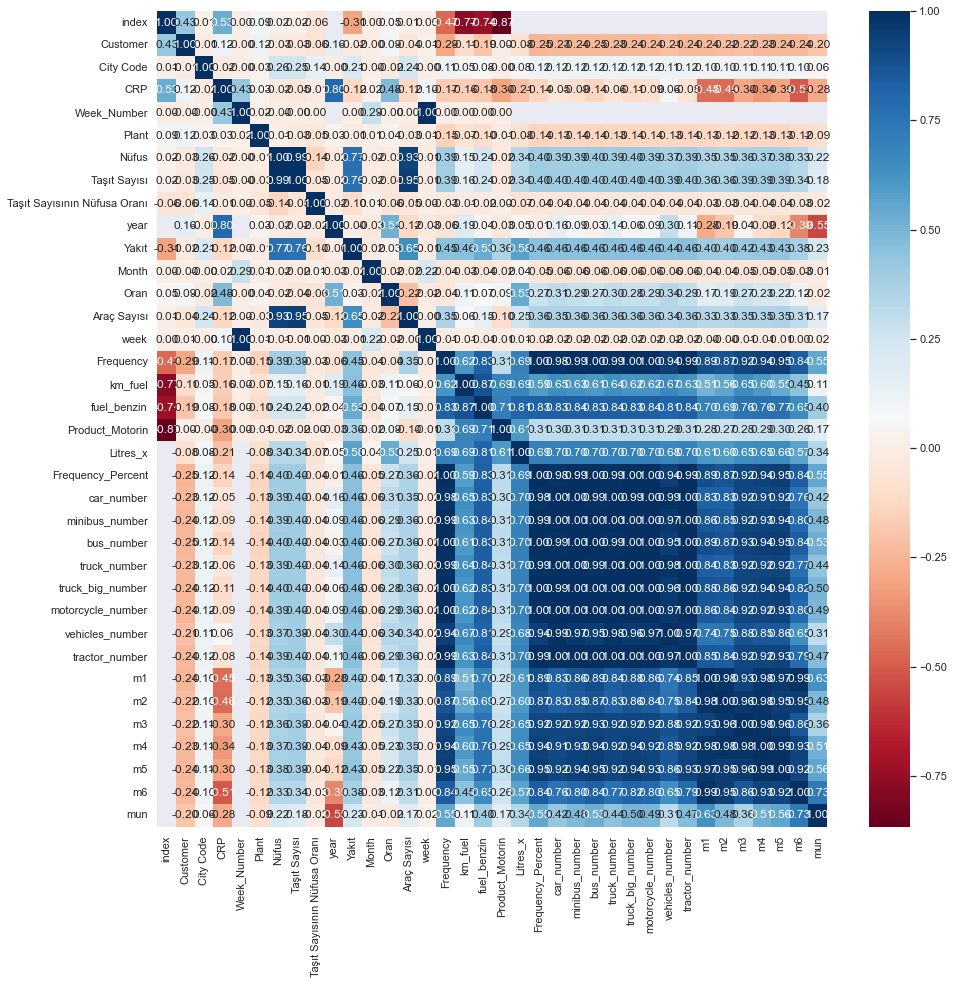

['Taşıt Sayısı',
 'Araç Sayısı',
 'week',
 'Frequency_Percent',
 'car_number',
 'minibus_number',
 'bus_number',
 'truck_number',
 'truck_big_number',
 'motorcycle_number',
 'vehicles_number',
 'tractor_number',
 'm2',
 'm3',
 'm4',
 'm5',
 'm6']

In [215]:
high_correlated_cols(new_df,plot=True)

In [115]:
fuel_14

,Year,Total,Gasoline,Diesel,LPG
0,2014,9857915,2855078,2882885,4076730


In [49]:
new_df["fuel_benzin"] = 0
new_df.loc[(new_df.year==2014)&(new_df.Product=="Benzin"),"fuel_benzin"] = new_df.loc[(new_df.year==2014)&(new_df.Product=="Benzin"),"Frequency_Percent"]*fuel_14.iloc[0,[2]][0]*t_14
new_df.loc[(new_df.year==2015)&(new_df.Product=="Benzin"),"fuel_benzin"] = new_df.loc[(new_df.year==2015)&(new_df.Product=="Benzin"),"Frequency_Percent"]*fuel_15.iloc[0,[2]][0]*t_15
new_df.loc[(new_df.year==2016)&(new_df.Product=="Benzin"),"fuel_benzin"] = new_df.loc[(new_df.year==2016)&(new_df.Product=="Benzin"),"Frequency_Percent"]*fuel_16.iloc[0,[2]][0]*t_16
new_df.loc[(new_df.year==2017)&(new_df.Product=="Benzin"),"fuel_benzin"] = new_df.loc[(new_df.year==2017)&(new_df.Product=="Benzin"),"Frequency_Percent"]*fuel_17.iloc[0,[2]][0]*t_17
new_df.loc[(new_df.year==2018)&(new_df.Product=="Benzin"),"fuel_benzin"] = new_df.loc[(new_df.year==2018)&(new_df.Product=="Benzin"),"Frequency_Percent"]*fuel_18.iloc[0,[2]][0]*t_18
new_df.loc[(new_df.year==2019)&(new_df.Product=="Benzin"),"fuel_benzin"] = new_df.loc[(new_df.year==2019)&(new_df.Product=="Benzin"),"Frequency_Percent"]*fuel_19.iloc[0,[2]][0]*t_19


new_df.loc[(new_df.year==2014)&(new_df.Product=="Motorin"),"fuel_benzin"] = new_df.loc[(new_df.year==2014)&(new_df.Product=="Motorin"),"Frequency_Percent"]*fuel_14.iloc[0,[3,4]].sum()*t_14
new_df.loc[(new_df.year==2015)&(new_df.Product=="Motorin"),"fuel_benzin"] = new_df.loc[(new_df.year==2015)&(new_df.Product=="Motorin"),"Frequency_Percent"]*fuel_15.iloc[0,[3,4]].sum()*t_15
new_df.loc[(new_df.year==2016)&(new_df.Product=="Motorin"),"fuel_benzin"] = new_df.loc[(new_df.year==2016)&(new_df.Product=="Motorin"),"Frequency_Percent"]*fuel_16.iloc[0,[3,4]].sum()*t_16
new_df.loc[(new_df.year==2017)&(new_df.Product=="Motorin"),"fuel_benzin"] = new_df.loc[(new_df.year==2017)&(new_df.Product=="Motorin"),"Frequency_Percent"]*fuel_17.iloc[0,[3,4]].sum()*t_17
new_df.loc[(new_df.year==2018)&(new_df.Product=="Motorin"),"fuel_benzin"] = new_df.loc[(new_df.year==2018)&(new_df.Product=="Motorin"),"Frequency_Percent"]*fuel_18.iloc[0,[3,4]].sum()*t_18
new_df.loc[(new_df.year==2019)&(new_df.Product=="Motorin"),"fuel_benzin"] = new_df.loc[(new_df.year==2019)&(new_df.Product=="Motorin"),"Frequency_Percent"]*fuel_19.iloc[0,[3,4]].sum()*t_19

In [591]:
new_df["fuel_motorin"] = 0
new_df.loc[(new_df.year==2014)&(new_df.Product=="Motorin"),"fuel_motorin"] = new_df.loc[(new_df.year==2014)&(new_df.Product=="Motorin"),"Frequency_Percent"]*fuel_14.iloc[0,[3,4]].sum()*100
new_df.loc[(new_df.year==2015)&(new_df.Product=="Motorin"),"fuel_motorin"] = new_df.loc[(new_df.year==2015)&(new_df.Product=="Motorin"),"Frequency_Percent"]*fuel_15.iloc[0,[3,4]].sum()*100
new_df.loc[(new_df.year==2016)&(new_df.Product=="Motorin"),"fuel_motorin"] = new_df.loc[(new_df.year==2016)&(new_df.Product=="Motorin"),"Frequency_Percent"]*fuel_16.iloc[0,[3,4]].sum()*100
new_df.loc[(new_df.year==2017)&(new_df.Product=="Motorin"),"fuel_motorin"] = new_df.loc[(new_df.year==2017)&(new_df.Product=="Motorin"),"Frequency_Percent"]*fuel_17.iloc[0,[3,4]].sum()*100
new_df.loc[(new_df.year==2018)&(new_df.Product=="Motorin"),"fuel_motorin"] = new_df.loc[(new_df.year==2018)&(new_df.Product=="Motorin"),"Frequency_Percent"]*fuel_18.iloc[0,[3,4]].sum()*100
new_df.loc[(new_df.year==2019)&(new_df.Product=="Motorin"),"fuel_motorin"] = new_df.loc[(new_df.year==2019)&(new_df.Product=="Motorin"),"Frequency_Percent"]*fuel_19.iloc[0,[3,4]].sum()*100

In [592]:
new_df["fuel_benzin_to"] = 1
new_df.loc[(new_df.year==2014)&(new_df.Product=="Benzin"),"fuel_benzin_to"] = new_df.loc[(new_df.year==2014),"fuel_benzin_to"]*fuel_14.iloc[0,[2]][0]
new_df.loc[(new_df.year==2015)&(new_df.Product=="Benzin"),"fuel_benzin_to"] = new_df.loc[(new_df.year==2015),"fuel_benzin_to"]*fuel_15.iloc[0,[2]][0]
new_df.loc[(new_df.year==2016)&(new_df.Product=="Benzin"),"fuel_benzin_to"] = new_df.loc[(new_df.year==2016),"fuel_benzin_to"]*fuel_16.iloc[0,[2]][0]
new_df.loc[(new_df.year==2017)&(new_df.Product=="Benzin"),"fuel_benzin_to"] = new_df.loc[(new_df.year==2017),"fuel_benzin_to"]*fuel_17.iloc[0,[2]][0]
new_df.loc[(new_df.year==2018)&(new_df.Product=="Benzin"),"fuel_benzin_to"] = new_df.loc[(new_df.year==2018),"fuel_benzin_to"]*fuel_18.iloc[0,[2]][0]
new_df.loc[(new_df.year==2019)&(new_df.Product=="Benzin"),"fuel_benzin_to"] = new_df.loc[(new_df.year==2019),"fuel_benzin_to"]*fuel_19.iloc[0,[2]][0]

new_df.loc[(new_df.year==2014)&(new_df.Product=="Motorin"),"fuel_benzin_to"] = new_df.loc[(new_df.year==2014),"fuel_benzin_to"]*fuel_14.iloc[0,[3,4]].sum()
new_df.loc[(new_df.year==2015)&(new_df.Product=="Motorin"),"fuel_benzin_to"] = new_df.loc[(new_df.year==2015),"fuel_benzin_to"]*fuel_15.iloc[0,[3,4]].sum()
new_df.loc[(new_df.year==2016)&(new_df.Product=="Motorin"),"fuel_benzin_to"] = new_df.loc[(new_df.year==2016),"fuel_benzin_to"]*fuel_16.iloc[0,[3,4]].sum()
new_df.loc[(new_df.year==2017)&(new_df.Product=="Motorin"),"fuel_benzin_to"] = new_df.loc[(new_df.year==2017),"fuel_benzin_to"]*fuel_17.iloc[0,[3,4]].sum()
new_df.loc[(new_df.year==2018)&(new_df.Product=="Motorin"),"fuel_benzin_to"] = new_df.loc[(new_df.year==2018),"fuel_benzin_to"]*fuel_18.iloc[0,[3,4]].sum()
new_df.loc[(new_df.year==2019)&(new_df.Product=="Motorin"),"fuel_benzin_to"] = new_df.loc[(new_df.year==2019),"fuel_benzin_to"]*fuel_19.iloc[0,[3,4]].sum()

In [593]:
new_df["fuel_motorin_to"] = 1
new_df.loc[(new_df.year==2014)&(new_df.Product=="Motorin"),"fuel_motorin_to"] = new_df.loc[(new_df.year==2014),"fuel_motorin_to"]*fuel_14.iloc[0,[3,4]].sum()
new_df.loc[(new_df.year==2015)&(new_df.Product=="Motorin"),"fuel_motorin_to"] = new_df.loc[(new_df.year==2015),"fuel_motorin_to"]*fuel_15.iloc[0,[3,4]].sum()
new_df.loc[(new_df.year==2016)&(new_df.Product=="Motorin"),"fuel_motorin_to"] = new_df.loc[(new_df.year==2016),"fuel_motorin_to"]*fuel_16.iloc[0,[3,4]].sum()
new_df.loc[(new_df.year==2017)&(new_df.Product=="Motorin"),"fuel_motorin_to"] = new_df.loc[(new_df.year==2017),"fuel_motorin_to"]*fuel_17.iloc[0,[3,4]].sum()
new_df.loc[(new_df.year==2018)&(new_df.Product=="Motorin"),"fuel_motorin_to"] = new_df.loc[(new_df.year==2018),"fuel_motorin_to"]*fuel_18.iloc[0,[3,4]].sum()
new_df.loc[(new_df.year==2019)&(new_df.Product=="Motorin"),"fuel_motorin_to"] = new_df.loc[(new_df.year==2019),"fuel_motorin_to"]*fuel_19.iloc[0,[3,4]].sum()

In [599]:
new_df.drop(["fuel_motorin_to"],axis=1,inplace=True)

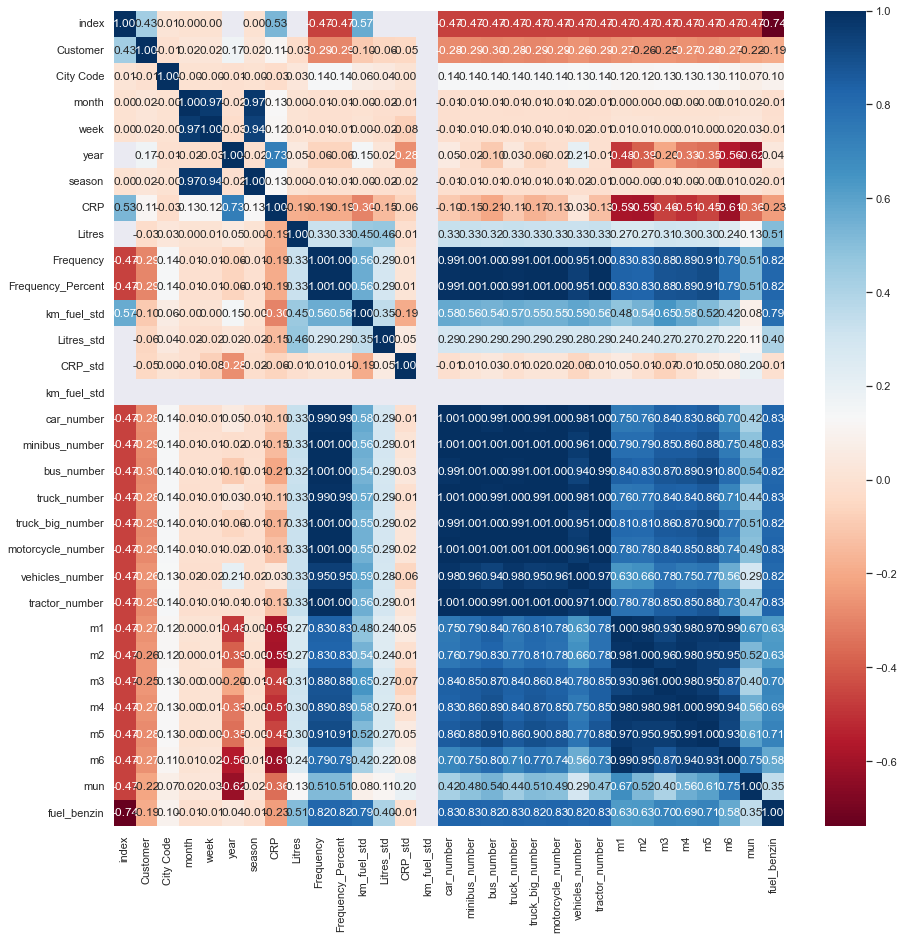

['week',
 'season',
 'Frequency_Percent',
 'km_fuel_std',
 'km_fuel_std',
 'car_number',
 'minibus_number',
 'bus_number',
 'truck_number',
 'truck_big_number',
 'motorcycle_number',
 'vehicles_number',
 'tractor_number',
 'm2',
 'm3',
 'm4',
 'm5',
 'm6']

In [122]:
high_correlated_cols(new_df,plot=True)

In [655]:
#new_df["m1_car"] = new_df["m1"]*(new_df["car_numbers"] # engine vs number of vehicles

In [136]:
new_df.drop(["date_of_price","week"],axis=1,inplace=True)

In [76]:
train

,Customer,Billing Date,Litres_x,Area,City Code,Product,Plant,CRP,Sehir,Nüfus,Taşıt Sayısı,Taşıt Sayısının Nüfusa Oranı,year,Yakıt,Month,Oran,Araç Sayısı,week,ind,Litres_y,Frequency,Frequency_Percent,km_fuel,fuel_benzin,Product_Motorin
0,10048261.000,2014-01-05,4242.000,Karadeniz Bölgesi,883.000,Benzin,9.000,5.070,Ordu,771932.000,135490.000,17.600,2014,1265.000,0.700,0.290,467206.897,1,train,0.000,627.000,0.043,0.000,21182.246,0.000
1,10048261.000,2014-01-12,13886.000,Karadeniz Bölgesi,883.000,Benzin,9.000,4.490,Ordu,771932.000,135490.000,17.600,2014,1265.000,0.700,0.290,467206.897,2,train,4242.000,627.000,0.043,0.000,21182.246,0.000
2,10048261.000,2014-01-19,10549.000,Karadeniz Bölgesi,883.000,Benzin,9.000,4.980,Ordu,771932.000,135490.000,17.600,2014,1265.000,0.700,0.290,467206.897,3,train,4179.000,627.000,0.043,0.000,21182.246,0.000
3,10048261.000,2014-01-26,9037.000,Karadeniz Bölgesi,883.000,Benzin,9.000,5.110,Ordu,771932.000,135490.000,17.600,2014,1265.000,0.700,0.290,467206.897,4,train,5527.000,627.000,0.043,0.000,21182.246,0.000
4,10048261.000,2014-02-02,8692.000,Karadeniz Bölgesi,883.000,Benzin,9.000,5.110,Ordu,771932.000,135490.000,17.600,2014,1265.000,0.710,0.290,467206.897,5,train,4184.000,627.000,0.043,0.000,21182.246,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437501,12614364.000,2018-12-02,30037.000,Doğu Anadolu Bölgesi,304.000,Motorin,5.000,6.270,Bitlis,349396.000,23975.080,6.500,2018,2200.000,0.770,0.368,65149.674,48,train,27120.000,155.000,0.011,0.019,15641.676,1.000
437502,12614364.000,2018-12-09,31036.000,Doğu Anadolu Bölgesi,304.000,Motorin,5.000,6.200,Bitlis,349396.000,23975.080,6.500,2018,2200.000,0.770,0.368,65149.674,49,train,30037.000,155.000,0.011,0.019,15641.676,1.000
437503,12614364.000,2018-12-16,46187.000,Doğu Anadolu Bölgesi,304.000,Motorin,5.000,6.200,Bitlis,349396.000,23975.080,6.500,2018,2200.000,0.770,0.368,65149.674,50,train,31036.000,155.000,0.011,0.019,15641.676,1.000
437504,12614364.000,2018-12-23,31062.000,Doğu Anadolu Bölgesi,304.000,Motorin,5.000,6.200,Bitlis,349396.000,23975.080,6.500,2018,2200.000,0.770,0.368,65149.674,51,train,20118.000,155.000,0.011,0.019,15641.676,1.000


In [216]:
# verideki türleri ayrıştıralım
def grab_col(dataframe,cat_threshold=10,car_threshold=20):
    cat_cols=[col for col in dataframe.columns if dataframe[col].dtypes in ["object","category","bool"]]
    num_but_cat=[col for col in dataframe.columns if dataframe[col].dtypes in ["int64","float64"] and dataframe[col].nunique()<=cat_threshold]
    num_cols=[col for col in dataframe.columns if dataframe[col].dtypes in ["int64","float64"] and col not in num_but_cat]
    cat_but_car=[col for col in cat_cols if dataframe[col].nunique()>car_threshold]
    cat_cols=cat_cols+num_but_cat
    cat_cols=[col for col in cat_cols if col not in cat_but_car]
    #print(f"Observations:{dataframe.shape[0]}")
    #print(f"Variables:{dataframe.shape[1]}")
    #print(f"cat_cols:{len(cat_cols)}")
   # print(f"num_cols:{len(num_cols)}")
   # print(f"cat_but_car:{len(cat_but_car)}")
   # print(f"num_but_cat:{len(num_but_cat)}")

    return cat_cols,num_cols,cat_but_car

In [217]:
cat_cols,num_cols,cat_but_car = grab_col(new_df)

In [218]:
cat_cols

['Area', 'Product', '_merge', 'ind', 'year', 'Product_Motorin']

In [219]:
new_df.drop(["_merge"],axis=1,inplace=True)

In [342]:
# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# generate dataset

fs = SelectKBest(score_func=f_regression, k=10)
# apply feature selection
X_selected = fs.fit_transform(X.drop("Week_Number",axis=1), y)
print(X_selected.shape)

(437506, 10)


In [351]:
list(fs.get_feature_names_out())

['Nüfus',
 'Taşıt Sayısı',
 'Yakıt',
 'Frequency',
 'km_fuel',
 'fuel_benzin',
 'Frequency_Percent',
 'km_fuel_new',
 'Product_Motorin',
 'Product_Motorin_1.0']

In [220]:
cat_cols

['Area', 'Product', '_merge', 'ind', 'year', 'Product_Motorin']

In [75]:
num_cols

['Customer',
 'Litres_x',
 'City Code',
 'Plant',
 'CRP',
 'Nüfus',
 'Taşıt Sayısı',
 'Taşıt Sayısının Nüfusa Oranı',
 'Yakıt',
 'Month',
 'Araç Sayısı',
 'week',
 'Litres_y',
 'Frequency',
 'Frequency_Percent',
 'km_fuel',
 'fuel_benzin']

In [221]:
cat_cols = ['Product',  'year',"Area"] 

In [222]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [223]:
df = one_hot_encoder(new_df,cat_cols)

In [99]:
test = one_hot_encoder(test,cat_cols)

In [302]:
# Custom Cost Function
########################

# MAE, MSE, RMSE, SSE

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [76]:
train.shape

(437506, 122)

In [224]:
test, train = df[df["ind"].eq("test")], df[df["ind"].eq("train")]

In [575]:
test, train = new_df[new_df["ind"].eq("test")], new_df[new_df["ind"].eq("train")]

In [452]:
train

,index,Customer,City Code,Billing Date,CRP,Week_Number,Plant,Sehir,Nüfus,Taşıt Sayısı,Taşıt Sayısının Nüfusa Oranı,Yakıt,Month,Araç Sayısı,week,Frequency,km_fuel,fuel_benzin,Product_Motorin,ind,Litres_x,Frequency_Percent,Area_y,area_percent_customer_product,km_fuel_new,car_number,minibus_number,bus_number,truck_number,truck_big_number,motorcycle_number,vehicles_number,tractor_number,m1,m2,m3,m4,m5,m6,mun,Product_Motorin,year_2015,year_2016,year_2017,year_2018,year_2019,Oran_0.259,Oran_0.268,Oran_0.276,Oran_0.29,Oran_0.292,Oran_0.316,Oran_0.336,Oran_0.354,Oran_0.368,Oran_0.381,Oran_1.0,Area_x_Doğu Anadolu Bölgesi,Area_x_Ege Bölgesi,Area_x_Güneydoğu Anadolu Bölgesi,Area_x_Karadeniz Bölgesi,Area_x_Marmara Bölgesi,Area_x_İç Anadolu Bölgesi
52,NaN,10048261.000,883.000,2014-01-05,4.400,NaN,9.000,Ordu,771932.000,135490.000,17.600,7977.000,0.700,464006.849,1,870.000,0.001,71645.836,1.000,train,29017.000,0.059,304,0.056,0.000,548887.713,23790.016,11759.595,170518.522,43081.097,157488.702,2267.898,90587.744,5939.486,4577.389,6795.342,13281.939,1456.809,521.220,45.880,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
53,NaN,10048261.000,883.000,2014-01-12,3.970,NaN,9.000,Ordu,771932.000,135490.000,17.600,7977.000,0.700,464006.849,2,870.000,0.001,71645.836,1.000,train,55606.000,0.059,304,0.056,0.000,548887.713,23790.016,11759.595,170518.522,43081.097,157488.702,2267.898,90587.744,5939.486,4577.389,6795.342,13281.939,1456.809,521.220,45.880,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
54,NaN,10048261.000,883.000,2014-01-19,4.580,NaN,9.000,Ordu,771932.000,135490.000,17.600,7977.000,0.700,464006.849,3,870.000,0.001,71645.836,1.000,train,28758.000,0.059,304,0.056,0.000,548887.713,23790.016,11759.595,170518.522,43081.097,157488.702,2267.898,90587.744,5939.486,4577.389,6795.342,13281.939,1456.809,521.220,45.880,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
55,NaN,10048261.000,883.000,2014-01-26,4.580,NaN,9.000,Ordu,771932.000,135490.000,17.600,7977.000,0.700,464006.849,4,870.000,0.001,71645.836,1.000,train,46670.000,0.059,304,0.056,0.000,548887.713,23790.016,11759.595,170518.522,43081.097,157488.702,2267.898,90587.744,5939.486,4577.389,6795.342,13281.939,1456.809,521.220,45.880,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
56,NaN,10048261.000,883.000,2014-02-02,4.650,NaN,9.000,Ordu,771932.000,135490.000,17.600,7977.000,0.710,464006.849,5,870.000,0.001,71645.836,1.000,train,44307.000,0.059,304,0.056,0.000,548887.713,23790.016,11759.595,170518.522,43081.097,157488.702,2267.898,90587.744,5939.486,4577.389,6795.342,13281.939,1456.809,521.220,45.880,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545973,NaN,10054977.000,150.000,2014-09-28,4.350,NaN,5.000,Batman,599103.000,45301.000,7.600,2719.000,1.050,155140.411,39,54.000,0.000,4446.983,1.000,train,6157.000,0.004,21,0.004,0.000,37916.585,1643.389,812.340,11779.240,2975.997,10879.154,156.664,6257.706,410.293,316.201,469.415,917.502,100.635,36.005,3.169,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
545974,NaN,10054977.000,150.000,2014-10-05,4.280,NaN,5.000,Batman,599103.000,45301.000,7.600,2719.000,0.970,155140.411,40,54.000,0.000,4446.983,1.000,train,10009.000,0.004,21,0.004,0.000,37916.585,1643.389,812.340,11779.240,2975.997,10879.154,156.664,6257.706,410.293,316.201,469.415,917.502,100.635,36.005,3.169,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
545975,NaN,10054977.000,150.000,2014-10-12,3.940,NaN,5.000,Batman,599103.000,45301.000,7.600,2719.000,0.970,155140.411,41,54.000,0.000,4446.983,1.000,train,7649.000,0.004,21,0.004,0.000,37916.585,1643.389,812.340,11779.240,2975.997,10879.154,156.664,6257.706,410.293,316.201,469.415,917.502,100.635,36.005,3.169,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
545976,NaN,10054977.000,150.000,2015-01-18,3.550,NaN,

In [320]:
# Converting sales to log(1+sales) # train süresini kısaltmak amacıyla
train['Litres_x'] = np.log1p(train["Litres_x"].values)

In [459]:
train.head()

,index,Customer,City Code,Billing Date,CRP,Week_Number,Plant,Sehir,Nüfus,Taşıt Sayısı,Taşıt Sayısının Nüfusa Oranı,Yakıt,Month,Araç Sayısı,week,Frequency,km_fuel,fuel_benzin,Product_Motorin,ind,Litres_x,Frequency_Percent,Area_y,area_percent_customer_product,km_fuel_new,car_number,minibus_number,bus_number,truck_number,truck_big_number,motorcycle_number,vehicles_number,tractor_number,m1,m2,m3,m4,m5,m6,mun,Product_Motorin,year_2015,year_2016,year_2017,year_2018,year_2019,Oran_0.259,Oran_0.268,Oran_0.276,Oran_0.29,Oran_0.292,Oran_0.316,Oran_0.336,Oran_0.354,Oran_0.368,Oran_0.381,Oran_1.0,Area_x_Doğu Anadolu Bölgesi,Area_x_Ege Bölgesi,Area_x_Güneydoğu Anadolu Bölgesi,Area_x_Karadeniz Bölgesi,Area_x_Marmara Bölgesi,Area_x_İç Anadolu Bölgesi
52,NaN,10048261.000,883.000,2014-01-05,4.400,NaN,9.000,Ordu,771932.000,135490.000,17.600,7977.000,0.700,464006.849,1,870.000,0.001,71645.836,1.000,train,29017.000,0.059,304,0.056,0.000,548887.713,23790.016,11759.595,170518.522,43081.097,157488.702,2267.898,90587.744,5939.486,4577.389,6795.342,13281.939,1456.809,521.220,45.880,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
53,NaN,10048261.000,883.000,2014-01-12,3.970,NaN,9.000,Ordu,771932.000,135490.000,17.600,7977.000,0.700,464006.849,2,870.000,0.001,71645.836,1.000,train,55606.000,0.059,304,0.056,0.000,548887.713,23790.016,11759.595,170518.522,43081.097,157488.702,2267.898,90587.744,5939.486,4577.389,6795.342,13281.939,1456.809,521.220,45.880,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
54,NaN,10048261.000,883.000,2014-01-19,4.580,NaN,9.000,Ordu,771932.000,135490.000,17.600,7977.000,0.700,464006.849,3,870.000,0.001,71645.836,1.000,train,28758.000,0.059,304,0.056,0.000,548887.713,23790.016,11759.595,170518.522,43081.097,157488.702,2267.898,90587.744,5939.486,4577.389,6795.342,13281.939,1456.809,521.220,45.880,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
55,NaN,10048261.000,883.000,2014-01-26,4.580,NaN,9.000,Ordu,771932.000,135490.000,17.600,7977.000,0.700,464006.849,4,870.000,0.001,71645.836,1.000,train,46670.000,0.059,304,0.056,0.000,548887.713,23790.016,11759.595,170518.522,43081.097,157488.702,2267.898,90587.744,5939.486,4577.389,6795.342,13281.939,1456.809,521.220,45.880,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
56,NaN,10048261.000,883.000,2014-02-02,4.650,NaN,9.000,Ordu,771932.000,135490.000,17.600,7977.000,0.710,464006.849,5,870.000,0.001,71645.836,1.000,train,44307.000,0.059,304,0.056,0.000,548887.713,23790.016,11759.595,170518.522,43081.097,157488.702,2267.898,90587.744,5939.486,4577.389,6795.342,13281.939,1456.809,521.220,45.880,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [576]:
train.head()

,index,Customer,Area,City Code,Billing Date_x,CRP_x,Week_Number,Plant_x,Sehir,Nüfus,Taşıt Sayısı,Taşıt Sayısının Nüfusa Oranı,year,Yakıt,Month,Oran,Araç Sayısı,week,Frequency,km_fuel,fuel_benzin,Product,CityCode,Billing Date_y,Litres,Plant_y,CRP_y,Day,USD/TRY,Population,VehiclesNumber,FuelAmount,TaxAmount,TaxRates,FuelConsumptionRate,Area_Doğu Anadolu Bölgesi,Area_Ege Bölgesi,Area_Güneydoğu Anadolu Bölgesi,Area_Karadeniz Bölgesi,Area_Marmara Bölgesi,Area_İç Anadolu Bölgesi,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,DayNames_Monday,DayNames_Saturday,DayNames_Sunday,DayNames_Thursday,DayNames_Tuesday,DayNames_Wednesday,MinumumWage_1000.54,MinumumWage_1300.99,MinumumWage_1404.0,MinumumWage_1603.0,MinumumWage_2020.59,FuelConsumption_24824703,FuelConsumption_26717671,FuelConsumption_26737750,FuelConsumption_27807223,FuelConsumption_28460979,Season_Spring,Season_Summer,Season_Winter,ind,Litres_x,Litres_y,Frequency_Percent,car_number,minibus_number,bus_number,truck_number,truck_big_number,motorcycle_number,vehicles_number,tractor_number,m1,m2,m3,m4,m5,m6,mun
0,NaN,10048261.000,Karadeniz Bölgesi,883.000,2014-01-05,5.070,NaN,9.000,Ordu,771932.000,135490.000,17.600,2014,1265.000,0.700,0.290,467206.897,1,627.000,0.000,21182.246,0.000,61.000,2014-01-03,5040.000,10.000,0.390,2.000,-0.697,-0.361,-0.626,-1.392,0.656,0.172,-0.292,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,train,4242.000,0.000,0.043,2858795.350,123906.560,61248.000,888118.910,224381.120,820255.140,11811.990,471812.020,30934.880,23840.610,35392.470,69176.890,7587.560,2714.690,238.960
1,NaN,10048261.000,Karadeniz Bölgesi,883.000,2014-01-05,5.070,NaN,9.000,Ordu,771932.000,135490.000,17.600,2014,1265.000,0.700,0.290,467206.897,1,627.000,0.000,21182.246,0.000,61.000,2014-12-30,3886.000,1.000,-0.297,29.000,-0.613,-0.361,-0.626,-0.916,0.656,0.922,-0.292,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,train,4242.000,0.000,0.043,2858795.350,123906.560,61248.000,888118.910,224381.120,820255.140,11811.990,471812.020,30934.880,23840.610,35392.470,69176.890,7587.560,2714.690,238.960
2,NaN,10048261.000,Karadeniz Bölgesi,883.000,2014-01-12,4.490,NaN,9.000,Ordu,771932.000,135490.000,17.600,2014,1265.000,0.700,0.290,467206.897,2,627.000,0.000,21182.246,0.000,61.000,2014-01-08,4242.000,10.000,0.305,7.000,-0.765,-0.361,-0.626,-1.342,0.656,0.252,-0.292,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,train,13886.000,4242.000,0.043,2858795.350,123906.560,61248.000,888118.910,224381.120,820255.140,11811.990,471812.020,30934.880,23840.610,35392.470,69176.890,7587.560,2714.690,238.960
3,NaN,10048261.000,Karadeniz Bölgesi,883.000,2014-01-19,4.980,NaN,9.000,Ordu,771932.000,135490.000,17.600,2014,1265.000,0.700,0.290,467206.897,3,627.000,0.000,21182.246,0.000,61.000,2014-01-14,4179.000,10.000,0.271,13.000,-0.731,-0.361,-0.626,-1.321,0.656,0.284,-0.292,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,train,10549.000,4179.000,0.043,2858795.350,123906.560,61248.000,888118.910,224381.120,820255.140,11811.990,471812.020,30934.880,23840.610,35392.470,69176.890,7587.560,2714.690,238.960
4,NaN,10048261.000,Karadeniz Bölgesi,883.000,201

In [54]:
train.head(1)

,index,Customer,City Code,Billing Date,CRP,Week_Number,Plant,Nüfus,Taşıt Sayısı,Taşıt Sayısının Nüfusa Oranı,Yakıt,Month,Oran,Araç Sayısı,week,Frequency,km_fuel,fuel_benzin,ind,Litres_x,Frequency_Percent,car_number,minibus_number,bus_number,truck_number,truck_big_number,motorcycle_number,vehicles_number,tractor_number,m1,m2,m3,m4,m5,m6,mun,Product_Motorin,year_2015,year_2016,year_2017,year_2018,year_2019,Area_Doğu Anadolu Bölgesi,Area_Ege Bölgesi,Area_Güneydoğu Anadolu Bölgesi,Area_Karadeniz Bölgesi,Area_Marmara Bölgesi,Area_İç Anadolu Bölgesi,Sehir_Adıyaman,Sehir_Afyonkarahisar,Sehir_Aksaray,Sehir_Amasya,Sehir_Ankara,Sehir_Antalya,Sehir_Ardahan,Sehir_Artvin,Sehir_Aydın,Sehir_Balıkesir,Sehir_Bartın,Sehir_Batman,Sehir_Bilecik,Sehir_Bingöl,Sehir_Bitlis,Sehir_Bolu,Sehir_Burdur,Sehir_Bursa,Sehir_Denizli,Sehir_Diyarbakır,Sehir_Düzce,Sehir_Edirne,Sehir_Elazığ,Sehir_Erzincan,Sehir_Erzurum,Sehir_Eskişehir,Sehir_Gaziantep,Sehir_Giresun,Sehir_Gümüşhane,Sehir_Hatay,Sehir_Isparta,Sehir_Kahramanmaraş,Sehir_Karabük,Sehir_Karaman,Sehir_Kars,Sehir_Kastamonu,Sehir_Kayseri,Sehir_Kilis,Sehir_Kocaeli,Sehir_Konya,Sehir_Kütahya,Sehir_Kırklareli,Sehir_Kırıkkale,Sehir_Kırşehir,Sehir_Malatya,Sehir_Manisa,Sehir_Mardin,Sehir_Mersin,Sehir_Muğla,Sehir_Muş,Sehir_Nevşehir,Sehir_Niğde,Sehir_Ordu,Sehir_Osmaniye,Sehir_Rize,Sehir_Sakarya,Sehir_Samsun,Sehir_Siirt,Sehir_Sinop,Sehir_Sivas,Sehir_Tekirdağ,Sehir_Tokat,Sehir_Trabzon,Sehir_Uşak,Sehir_Van,Sehir_Yalova,Sehir_Yozgat,Sehir_Zonguldak,Sehir_Çanakkale,Sehir_Çankırı,Sehir_Çorum,Sehir_İstanbul,Sehir_İzmir,Sehir_Şanlıurfa
0,NaN,10048261.000,883.000,2014-01-05,5.070,NaN,9.000,771932.000,135490.000,17.600,1265.000,0.700,0.290,467206.897,1,627.000,0.000,21182.246,train,4242.000,0.043,522.704,22.655,11.199,162.384,41.026,149.976,2.160,86.266,5.656,4.359,6.471,12.648,1.387,0.496,0.044,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [321]:
X = train.drop(["index","Customer","Billing Date","ind","Litres_x","City Code","Week_Number","week","Sehir"],axis=1)
y = train["Litres_x"]

In [235]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [322]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=24)

In [155]:
#cols = ['CRP', 'Frequency', 'Frequency_Percent', 'km_fuel', 'car_number', 'minibus_number', 'bus_number', 'truck_number', 'motorcycle_number', 'vehicles_number', 'truck_big_number', 'tractor_number', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'mun', 'fuel_benzin', 'fuel_motorin', 'month', 'Area_Doğu Anadolu Bölgesi', 'Area_Ege Bölgesi', 'Area_Güneydoğu Anadolu Bölgesi', 'Area_Karadeniz Bölgesi', 'Area_Marmara Bölgesi',
 #      'Area_İç Anadolu Bölgesi', 'Product_Motorin', 'Plant_T102', 'Plant_T105', 'Plant_T107', 'Plant_T108', 'Plant_T110', 'Plant_T111', 'Plant_T112', 'Plant_T113', 'Plant_T120', 'Plant_T155', 'Plant_T248', 'Plant_T314', 'Plant_T317', 'Plant_T318', 'Plant_T327', 'Plant_T329', 'year_2015', 'year_2016', 'year_2017', 'year_2018']

In [316]:
import lightgbm as lgb

In [317]:
list(X.columns)

['CRP',
 'Plant',
 'Nüfus',
 'Taşıt Sayısı',
 'Taşıt Sayısının Nüfusa Oranı',
 'Yakıt',
 'Month',
 'Oran',
 'Araç Sayısı',
 'Frequency',
 'km_fuel',
 'fuel_benzin',
 'Product',
 'Frequency_Percent',
 'car_number',
 'minibus_number',
 'bus_number',
 'truck_number',
 'truck_big_number',
 'motorcycle_number',
 'vehicles_number',
 'tractor_number',
 'm1',
 'm2',
 'm3',
 'm4',
 'm5',
 'm6',
 'mun',
 'year_2015',
 'year_2016',
 'year_2017',
 'year_2018',
 'year_2019',
 'Area_Doğu Anadolu Bölgesi',
 'Area_Ege Bölgesi',
 'Area_Güneydoğu Anadolu Bölgesi',
 'Area_Karadeniz Bölgesi',
 'Area_Marmara Bölgesi',
 'Area_İç Anadolu Bölgesi']

In [308]:
train.columns =['index', 'Customer', 'City Code', 'Billing Date', 'CRP', 'Week_Number', 'Plant', 'Sehir', 'Nüfus', 'Taşıt Sayısı', 'Taşıt Sayısının Nüfusa Oranı', 'Yakıt', 'Month', 'Oran', 'Araç Sayısı', 'week', 'Frequency', 'km_fuel', 'fuel_benzin', 'Product', 'ind', 'Litres_x', 'Frequency_Percent', 'car_number', 'minibus_number', 'bus_number', 'truck_number', 'truck_big_number', 'motorcycle_number', 'vehicles_number', 'tractor_number', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'mun',
       'Product_Motorin', 'year_2015', 'year_2016', 'year_2017', 'year_2018', 'year_2019', 'Area_Doğu Anadolu Bölgesi', 'Area_Ege Bölgesi', 'Area_Güneydoğu Anadolu Bölgesi', 'Area_Karadeniz Bölgesi', 'Area_Marmara Bölgesi', 'Area_İç Anadolu Bölgesi']

In [312]:
test.columns = ['index', 'Customer', 'City Code', 'Billing Date', 'CRP', 'Week_Number', 'Plant', 'Sehir', 'Nüfus', 'Taşıt Sayısı', 'Taşıt Sayısının Nüfusa Oranı', 'Yakıt', 'Month', 'Oran', 'Araç Sayısı', 'week', 'Frequency', 'km_fuel', 'fuel_benzin', 'Product', 'ind', 'Litres_x', 'Frequency_Percent', 'car_number', 'minibus_number', 'bus_number', 'truck_number', 'truck_big_number', 'motorcycle_number', 'vehicles_number', 'tractor_number', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'mun',
       'Product_Motorin', 'year_2015', 'year_2016', 'year_2017', 'year_2018', 'year_2019', 'Area_Doğu Anadolu Bölgesi', 'Area_Ege Bölgesi', 'Area_Güneydoğu Anadolu Bölgesi', 'Area_Karadeniz Bölgesi', 'Area_Marmara Bölgesi', 'Area_İç Anadolu Bölgesi']

In [313]:
test.drop("Product_Motorin",axis=1,inplace=True)

In [318]:
cols =['CRP',
 'Plant',
 'Nüfus',
 'Taşıt Sayısı',
 'Taşıt Sayısının Nüfusa Oranı',
 'Yakıt',
 'Month',
 'Oran',
 'Araç Sayısı',
 'Frequency',
 'km_fuel',
 'fuel_benzin',
 'Product',
 'Frequency_Percent',
 'car_number',
 'minibus_number',
 'bus_number',
 'truck_number',
 'truck_big_number',
 'motorcycle_number',
 'vehicles_number',
 'tractor_number',
 'm1',
 'm2',
 'm3',
 'm4',
 'm5',
 'm6',
 'mun',
 'year_2015',
 'year_2016',
 'year_2017',
 'year_2018',
 'year_2019',
 'Area_Doğu Anadolu Bölgesi',
 'Area_Ege Bölgesi',
 'Area_Güneydoğu Anadolu Bölgesi',
 'Area_Karadeniz Bölgesi',
 'Area_Marmara Bölgesi',
 'Area_İç Anadolu Bölgesi']

In [ ]:
# LightGBM ile Zaman Serisi Modeli

# !pip install lightgbm
# conda install lightgbm


# LightGBM parameters
lgb_params = {'num_leaves': 2,
              "objective": "regression",
              "boosting_type": "gbdt",
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': -1,
              'num_boost_round': 1000,
              'early_stopping_rounds':200,
              'nthread': -1}

# metric mae: l1, absolute loss, mean_absolute_error, regression_l1
# mse: l2, square loss, mean_squared_error, mse, regression_l2, regression
# rmse, root square loss, root_mean_squared_error, l2_root
# mape, MAPE loss, mean_absolute_percentage_error

# num_leaves: bir ağaçtaki maksimum yaprak sayısı
# learning_rate: shrinkage_rate, eta
# feature_fraction: rf'nin random subspace özelliği. her iterasyonda rastgele göz önünde bulundurulacak değişken sayısı.
# max_depth: maksimum derinlik
# num_boost_round: n_estimators, number of boosting iterations. En az 10000-15000 civarı yapmak lazım.

# early_stopping_rounds: validasyon setindeki metrik belirli bir early_stopping_rounds'da ilerlemiyorsa yani
# hata düşmüyorsa modellemeyi durdur.
# hem train süresini kısaltır hem de overfit'e engel olur.
# nthread: num_thread, nthread, nthreads, n_jobs

lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_test, label=y_test, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

y_pred_vawl = model.predict(X_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.397138	training's SMAPE: 47.5942	valid_1's l2: 0.397668	valid_1's SMAPE: 47.5184
[200]	training's l2: 0.321387	training's SMAPE: 42.435	valid_1's l2: 0.321821	valid_1's SMAPE: 42.3709
[300]	training's l2: 0.301587	training's SMAPE: 40.8198	valid_1's l2: 0.302335	valid_1's SMAPE: 40.7891
[400]	training's l2: 0.293029	training's SMAPE: 40.0873	valid_1's l2: 0.293931	valid_1's SMAPE: 40.0699


In [264]:
import catboost as cb
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

In [265]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

In [293]:
model = cb.CatBoostRegressor(loss_function="RMSE")

In [ ]:
grid = {'iterations': [500],
        'learning_rate': [0.02],
        'depth': [10],
        'l2_leaf_reg': [0.2
                       ]}
model.grid_search(grid, train_dataset)

In [288]:
pred = model.predict(X_test)

In [ ]:
pred = np.expm1(pred)

In [270]:
y_pred=abs(pred)

In [289]:
pred[pred<0]

array([-531.37502186])

In [291]:
from sklearn import metrics
print(metrics.mean_squared_log_error(y_test, abs(pred)))

0.22925256136920996


0.19318810344794674


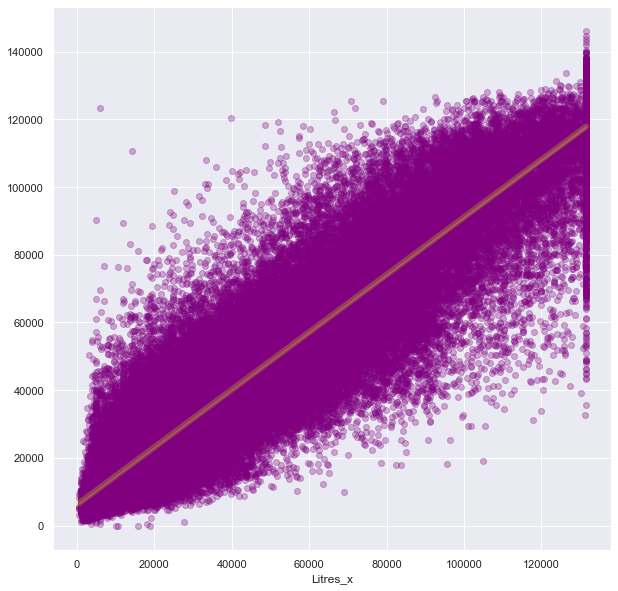

In [274]:
from sklearn import metrics
print(metrics.mean_squared_log_error(y_test, pred))
    
plt.figure(figsize=(10,10))
sns.regplot(y_test, pred, fit_reg=True,scatter_kws = {"color": "purple", "alpha": 0.3}, line_kws = {"color": "#CCCC00", "alpha": 0.3, "lw":6},truncate = True)
sns.set_style("whitegrid")

In [106]:
# Değişken Önem Düzeyleri
########################

def plot_lgb_importances(model, plot=False, num=10):
    gain = model.get_feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.get_feature_name(),
                             'split': model.get_feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(model, num=200)

plot_lgb_importances(model, num=30, plot=True)


feat_imp = plot_lgb_importances(model, num=200)

importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

CatBoostError: Invalid data type=<class 'str'>, must be catboost.Pool.

In [107]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(y_test,pred)

0.1388401710282523

In [171]:
test

,index,Customer,City Code,Billing Date,CRP,Week_Number,Plant,Nüfus,Taşıt Sayısı,Taşıt Sayısının Nüfusa Oranı,Yakıt,Month,Araç Sayısı,week,Frequency,km_fuel,fuel_benzin,_merge,ind,Litres_x,Frequency_Percent,Area_Doğu Anadolu Bölgesi,Area_Ege Bölgesi,Area_Güneydoğu Anadolu Bölgesi,Area_Karadeniz Bölgesi,Area_Marmara Bölgesi,Area_İç Anadolu Bölgesi,Product_Motorin,year_2015,year_2016,year_2017,year_2018,year_2019,Oran_0.259,Oran_0.268,Oran_0.276,Oran_0.29,Oran_0.292,Oran_0.316,Oran_0.336,Oran_0.354,Oran_0.368,Oran_0.381,Oran_1.0,Product_Motorin_1.0,Sehir_Adıyaman,Sehir_Afyonkarahisar,Sehir_Aksaray,Sehir_Amasya,Sehir_Ankara,Sehir_Antalya,Sehir_Ardahan,Sehir_Artvin,Sehir_Aydın,Sehir_Balıkesir,Sehir_Bartın,Sehir_Batman,Sehir_Bilecik,Sehir_Bingöl,Sehir_Bitlis,Sehir_Bolu,Sehir_Burdur,Sehir_Bursa,Sehir_Denizli,Sehir_Diyarbakır,Sehir_Düzce,Sehir_Edirne,Sehir_Elazığ,Sehir_Erzincan,Sehir_Erzurum,Sehir_Eskişehir,Sehir_Gaziantep,Sehir_Giresun,Sehir_Gümüşhane,Sehir_Hatay,Sehir_Isparta,Sehir_Kahramanmaraş,Sehir_Karabük,Sehir_Karaman,Sehir_Kars,Sehir_Kastamonu,Sehir_Kayseri,Sehir_Kilis,Sehir_Kocaeli,Sehir_Konya,Sehir_Kütahya,Sehir_Kırklareli,Sehir_Kırıkkale,Sehir_Kırşehir,Sehir_Malatya,Sehir_Manisa,Sehir_Mardin,Sehir_Mersin,Sehir_Muğla,Sehir_Muş,Sehir_Nevşehir,Sehir_Niğde,Sehir_Ordu,Sehir_Osmaniye,Sehir_Rize,Sehir_Sakarya,Sehir_Samsun,Sehir_Siirt,Sehir_Sinop,Sehir_Sivas,Sehir_Tekirdağ,Sehir_Tokat,Sehir_Trabzon,Sehir_Uşak,Sehir_Van,Sehir_Yalova,Sehir_Yozgat,Sehir_Zonguldak,Sehir_Çanakkale,Sehir_Çankırı,Sehir_Çorum,Sehir_İstanbul,Sehir_İzmir,Sehir_Şanlıurfa
0,0.000,10048261.000,883.000,2019-01-07,5.760,2.000,9.000,771932.000,135490.000,17.600,19498.000,0.700,355616.798,2,870.000,0.107,90048.937,NaN,test,NaN,NaN,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.000,10048261.000,883.000,2019-01-14,5.940,3.000,9.000,771932.000,135490.000,17.600,19498.000,0.700,355616.798,3,870.000,0.107,90048.937,NaN,test,NaN,NaN,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2.000,10048261.000,883.000,2019-01-21,6.140,4.000,9.000,771932.000,135490.000,17.600,19498.000,0.700,355616.798,4,870.000,0.107,90048.937,NaN,test,NaN,NaN,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3.000,10048261.000,883.000,2019-01-28,6.140,5.000,9.000,771932.000,135490.000,17.600,19498.000,0.700,355616.798,5,870.000,0.107,90048.937,NaN,test,NaN,NaN,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.000,10048261.000,883.000,2019-02-04,6.140,6.000,9.000,771932.000,135490.000,17.600,19498.000,0.710,355616.798,6,870.000,0.107,90048.937,NaN,test,NaN,NaN,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108467,108467.000,12739737.000,194.000,2019-12-02,7.140,49.000,5.000,1123784.000,78806.000,7.000,1311.000,0.770,206839.895,49,52.000,0.001,1723.435,NaN,test,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,1,0

In [145]:
train

,index,Customer,City Code,Billing Date,CRP,Week_Number,Plant,Nüfus,Taşıt Sayısı,Taşıt Sayısının Nüfusa Oranı,Yakıt,Month,Araç Sayısı,week,Frequency,km_fuel,fuel_benzin,_merge,ind,Litres_x,Frequency_Percent,Area_Doğu Anadolu Bölgesi,Area_Ege Bölgesi,Area_Güneydoğu Anadolu Bölgesi,Area_Karadeniz Bölgesi,Area_Marmara Bölgesi,Area_İç Anadolu Bölgesi,Product_Motorin,year_2015,year_2016,year_2017,year_2018,year_2019,Oran_0.259,Oran_0.268,Oran_0.276,Oran_0.29,Oran_0.292,Oran_0.316,Oran_0.336,Oran_0.354,Oran_0.368,Oran_0.381,Oran_1.0,Product_Motorin_1.0,Sehir_Adıyaman,Sehir_Afyonkarahisar,Sehir_Aksaray,Sehir_Amasya,Sehir_Ankara,Sehir_Antalya,Sehir_Ardahan,Sehir_Artvin,Sehir_Aydın,Sehir_Balıkesir,Sehir_Bartın,Sehir_Batman,Sehir_Bilecik,Sehir_Bingöl,Sehir_Bitlis,Sehir_Bolu,Sehir_Burdur,Sehir_Bursa,Sehir_Denizli,Sehir_Diyarbakır,Sehir_Düzce,Sehir_Edirne,Sehir_Elazığ,Sehir_Erzincan,Sehir_Erzurum,Sehir_Eskişehir,Sehir_Gaziantep,Sehir_Giresun,Sehir_Gümüşhane,Sehir_Hatay,Sehir_Isparta,Sehir_Kahramanmaraş,Sehir_Karabük,Sehir_Karaman,Sehir_Kars,Sehir_Kastamonu,Sehir_Kayseri,Sehir_Kilis,Sehir_Kocaeli,Sehir_Konya,Sehir_Kütahya,Sehir_Kırklareli,Sehir_Kırıkkale,Sehir_Kırşehir,Sehir_Malatya,Sehir_Manisa,Sehir_Mardin,Sehir_Mersin,Sehir_Muğla,Sehir_Muş,Sehir_Nevşehir,Sehir_Niğde,Sehir_Ordu,Sehir_Osmaniye,Sehir_Rize,Sehir_Sakarya,Sehir_Samsun,Sehir_Siirt,Sehir_Sinop,Sehir_Sivas,Sehir_Tekirdağ,Sehir_Tokat,Sehir_Trabzon,Sehir_Uşak,Sehir_Van,Sehir_Yalova,Sehir_Yozgat,Sehir_Zonguldak,Sehir_Çanakkale,Sehir_Çankırı,Sehir_Çorum,Sehir_İstanbul,Sehir_İzmir,Sehir_Şanlıurfa
0,NaN,10048261.000,883.000,2014-01-05,5.070,NaN,9.000,771932.000,135490.000,17.600,1265.000,0.700,467206.897,1,627.000,0.000,21182.246,NaN,train,4242.000,0.043,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NaN,10048261.000,883.000,2014-01-12,4.490,NaN,9.000,771932.000,135490.000,17.600,1265.000,0.700,467206.897,2,627.000,0.000,21182.246,NaN,train,13886.000,0.043,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NaN,10048261.000,883.000,2014-01-19,4.980,NaN,9.000,771932.000,135490.000,17.600,1265.000,0.700,467206.897,3,627.000,0.000,21182.246,NaN,train,10549.000,0.043,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,10048261.000,883.000,2014-01-26,5.110,NaN,9.000,771932.000,135490.000,17.600,1265.000,0.700,467206.897,4,627.000,0.000,21182.246,NaN,train,9037.000,0.043,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,10048261.000,883.000,2014-02-02,5.110,NaN,9.000,771932.000,135490.000,17.600,1265.000,0.710,467206.897,5,627.000,0.000,21182.246,NaN,train,8692.000,0.043,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437501,NaN,12614364.000,304.000,2018-12-02,6.270,NaN,5.000,349396.000,23975.080,6.500,2200.000,0.770,65149.674,48,155.000,0.019,15641.676,NaN,train,30037.000,0.011,1,0,0,0,0

In [144]:
test

,index,Customer,City Code,Billing Date,CRP,Week_Number,Plant,Nüfus,Taşıt Sayısı,Taşıt Sayısının Nüfusa Oranı,Yakıt,Month,Araç Sayısı,week,Frequency,km_fuel,fuel_benzin,_merge,ind,Litres_x,Frequency_Percent,Area_Doğu Anadolu Bölgesi,Area_Ege Bölgesi,Area_Güneydoğu Anadolu Bölgesi,Area_Karadeniz Bölgesi,Area_Marmara Bölgesi,Area_İç Anadolu Bölgesi,Product_Motorin,year_2015,year_2016,year_2017,year_2018,year_2019,Oran_0.259,Oran_0.268,Oran_0.276,Oran_0.29,Oran_0.292,Oran_0.316,Oran_0.336,Oran_0.354,Oran_0.368,Oran_0.381,Oran_1.0,Product_Motorin_1.0,Sehir_Adıyaman,Sehir_Afyonkarahisar,Sehir_Aksaray,Sehir_Amasya,Sehir_Ankara,Sehir_Antalya,Sehir_Ardahan,Sehir_Artvin,Sehir_Aydın,Sehir_Balıkesir,Sehir_Bartın,Sehir_Batman,Sehir_Bilecik,Sehir_Bingöl,Sehir_Bitlis,Sehir_Bolu,Sehir_Burdur,Sehir_Bursa,Sehir_Denizli,Sehir_Diyarbakır,Sehir_Düzce,Sehir_Edirne,Sehir_Elazığ,Sehir_Erzincan,Sehir_Erzurum,Sehir_Eskişehir,Sehir_Gaziantep,Sehir_Giresun,Sehir_Gümüşhane,Sehir_Hatay,Sehir_Isparta,Sehir_Kahramanmaraş,Sehir_Karabük,Sehir_Karaman,Sehir_Kars,Sehir_Kastamonu,Sehir_Kayseri,Sehir_Kilis,Sehir_Kocaeli,Sehir_Konya,Sehir_Kütahya,Sehir_Kırklareli,Sehir_Kırıkkale,Sehir_Kırşehir,Sehir_Malatya,Sehir_Manisa,Sehir_Mardin,Sehir_Mersin,Sehir_Muğla,Sehir_Muş,Sehir_Nevşehir,Sehir_Niğde,Sehir_Ordu,Sehir_Osmaniye,Sehir_Rize,Sehir_Sakarya,Sehir_Samsun,Sehir_Siirt,Sehir_Sinop,Sehir_Sivas,Sehir_Tekirdağ,Sehir_Tokat,Sehir_Trabzon,Sehir_Uşak,Sehir_Van,Sehir_Yalova,Sehir_Yozgat,Sehir_Zonguldak,Sehir_Çanakkale,Sehir_Çankırı,Sehir_Çorum,Sehir_İstanbul,Sehir_İzmir,Sehir_Şanlıurfa
0,0.000,10048261.000,883.000,2019-01-07,5.760,2.000,9.000,771932.000,135490.000,17.600,19498.000,0.700,355616.798,2,870.000,0.107,90048.937,both,test,NaN,NaN,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.000,10048261.000,883.000,2019-01-14,5.940,3.000,9.000,771932.000,135490.000,17.600,19498.000,0.700,355616.798,3,870.000,0.107,90048.937,both,test,NaN,NaN,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2.000,10048261.000,883.000,2019-01-21,6.140,4.000,9.000,771932.000,135490.000,17.600,19498.000,0.700,355616.798,4,870.000,0.107,90048.937,both,test,NaN,NaN,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3.000,10048261.000,883.000,2019-01-28,6.140,5.000,9.000,771932.000,135490.000,17.600,19498.000,0.700,355616.798,5,870.000,0.107,90048.937,both,test,NaN,NaN,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.000,10048261.000,883.000,2019-02-04,6.140,6.000,9.000,771932.000,135490.000,17.600,19498.000,0.710,355616.798,6,870.000,0.107,90048.937,both,test,NaN,NaN,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108467,108467.000,12739737.000,194.000,2019-12-02,7.140,49.000,5.000,1123784.000,78806.000,7.000,1311.000,0.770,206839.895,49,52.000,0.001,1723.435,both,test,NaN,NaN,1,0,0,0,0,0,0,0,0,0

In [275]:
new_test = test.drop(["index","Customer","Billing Date","ind","Litres_x","City Code","Week_Number","week","Sehir"],axis=1)

In [276]:
new_test.head().shape

(5, 41)

In [277]:
new_test = sc.transform(new_test)

In [278]:
y_pred = model.predict(new_test)
#y_pred = np.expm1(y_pred)

In [279]:
y_pred[y_pred<0]

array([], dtype=float64)

In [280]:
st = pd.read_csv("test.csv") 

In [281]:
st["Litres"] = y_pred

In [282]:
cc = st[["index","Litres"]]

In [283]:
cc.to_csv("merge_submission_new2.csv",index=False)

In [212]:
(cc["Litres"]==1).any()

False

In [162]:
import pandas as pd
new = pd.read_csv("new_s.csv")
data_4 = pd.read_csv("data4.csv")
game = pd.read_csv("game.csv")
gg = pd.read_csv("gg.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'new_s.csv'

In [351]:
from sklearn.metrics import  mean_squared_log_error
mean_squared_log_error(new["Litres"].values,cc["Litres"].values)

0.3381942382701145

In [353]:
from sklearn.metrics import  mean_squared_log_error
mean_squared_log_error(game["Litres"].values,cc["Litres"].values)

0.593739963018313

In [284]:
cc

,index,Litres
0,0,34832.411
1,1,40907.075
2,2,40822.887
3,3,40822.887
4,4,41125.987
...,...,...
108467,108467,11047.332
108468,108468,11047.332
108469,108469,11047.332
108470,108470,11047.332
